# LLaMA原理精讲与架构复现

- llama3架构一览

<center><img src="https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/06.png" alt="描述文字" width="600">

In [58]:
import math
import struct
import inspect
import time

import LMConfig
from typing import Any, Optional, Tuple
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from transformers import PreTrainedModel
from transformers.modeling_outputs import CausalLMOutputWithPast

## 1. Embedding层

在PyTorch中，`nn.Embedding`层是用于处理离散数据（如单词或类别）的关键组件，特别常见于自然语言处理（NLP）和推荐系统等任务。它的主要功能是将输入的整数索引映射到连续的高维向量空间中，即将**索引**转化为**嵌入向量**。

```python
torch.nn.Embedding(num_embeddings, embedding_dim)
```

- **`num_embeddings`**: 嵌入表的大小，即词汇表的大小或类别数。它定义了有多少个不同的“离散输入”可以映射到嵌入向量。
- **`embedding_dim`**: 每个离散输入（类别、单词等）将被映射到的连续向量的维度大小。

`nn.Embedding`的输入通常是整数（类别索引或词汇索引），它会根据输入的索引从一个大小为 `(num_embeddings, embedding_dim)` 的查找表中检索出相应的嵌入向量。

In [12]:
import torch
import torch.nn as nn

# 定义Embedding层
embedding = nn.Embedding(10, 3)  # num_embeddings=10, embedding_dim=3

# 输入索引
input_indices = torch.tensor([1, 2, 3])

# 获取嵌入向量
output = embedding(input_indices)

print(output)

tensor([[ 1.5522,  0.7179,  1.6805],
        [ 2.1118,  0.2995,  0.4167],
        [-0.6033, -0.4972, -1.6700]], grad_fn=<EmbeddingBackward0>)


- embedding层携带巨大的权重矩阵，是参数量计算的关键过程之一

In [14]:
print(embedding.weight) #结构为10,3

Parameter containing:
tensor([[ 0.4752, -0.2457,  0.2101],
        [ 1.5522,  0.7179,  1.6805],
        [ 2.1118,  0.2995,  0.4167],
        [-0.6033, -0.4972, -1.6700],
        [-0.8719, -0.7207,  0.8305],
        [ 1.2962, -1.2880,  0.8838],
        [-0.7804, -0.1872,  0.3502],
        [-0.2817, -0.9322,  0.5499],
        [-0.5277,  0.8808, -1.6055],
        [ 0.5706,  0.9455, -0.0734]], requires_grad=True)


## 2. RMSNorm 均方根层归一化

在Transformer结构中，Layer Normalization（层归一化）是一个至关重要的部分，它是一种特定的归一化技术，与Batch Normalization（批归一化）不同，Layer Normalization不是对一个批次（batch）中的样本进行归一化，而是独立地对每个样本中的所有特征进行归一化（也就是对单一词向量、单一时间点的所有embedding维度进行归一化）。具体来说，对于每个样本，Layer Normalization会在特定层的所有激活上计算均值和方差，然后用这些统计量来归一化该样本的激活值。

- **LN与BN的差别**

BN 和 LN 的差别就在$u_i$和 $\sigma_i$这里，前者在某一个 Batch 内统计某特定神经元节点的输出分布（跨样本），后者在某一次迭代更新中统计同一层内的所有神经元节点的输出分布（同一样本下）。
![Alt text](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/image-29.png)

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/19.png)

> * NLP任务中经常会处理长度不同的句子，使用LN时可以不考虑其它样本的长度。<br><br>
> * 在某些情况下，当可用的内存有限或者为了加速训练而使用更小的batch时，BN因为batch数量不足而受到了限制。<br><br>
> * 在某些NLP任务和解码设置中，模型可能会一个接一个地处理序列中的元素，而不是一次处理整个batch。这样BN就不是很适用了。<br><br>
> * 在Transformer模型中有很深的层次和自注意机制。通过对每一层的输入进行规范化，可以防止值的爆炸或消失，从而帮助模型更快地收敛。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/08.webp)

- **LN与RMSNorm的差别**

**RMSNorm** 和 **普通 LayerNorm** 的主要区别在于归一化的计算方式：

1. **归一化公式**：  
   - **LayerNorm** 会对输入特征的均值和方差进行计算，然后用这些统计量对每个特征进行归一化。
   - **RMSNorm** 只计算输入特征的均方根 (RMS, Root Mean Square)，而不考虑均值。因此，RMSNorm 去掉了均值的计算，直接利用每个特征的均方根进行归一化。
<br><br>
2. **计算简化**：  
   - **LayerNorm** 需要同时计算均值和方差，涉及更多的计算步骤。
   - **RMSNorm** 只需要计算输入的均方根，计算量更小。

- **更少的计算开销**：由于去除了对均值的计算，RMSNorm 的计算开销相比 LayerNorm 更小，尤其在大规模模型中表现更为高效。
- **训练稳定性**：RMSNorm 保留了归一化的效果，能够稳定训练过程，同时在某些场景下表现出更好的收敛性。
- **适合大模型**：RMSNorm 因其简化的计算过程，特别适合像 LLaMA 这样的大模型，可以提高训练和推理的效率。
- **统计概念不同**：均方根 (RMS) 是数据点平方的均值再开平方，表达的是数据的“绝对大小”，忽略了数据的符号，反映的是整体数据的幅度或能量，均值和方差则更多代表波动，更关注数据的分布，包括数据的中心位置和离散程度。

In [ ]:
class RMSNorm(torch.nn.Module):
    # 初始化函数，接受参数：
    # dim: 归一化的维度大小
    # eps: 防止除零的非常小的数值
    def __init__(self, dim: int, eps: float):
        super().__init__()  # 调用父类的初始化方法
        self.eps = eps  # 将 eps 存储为类的属性
        # 初始化可学习的参数 weight，初始值为全1，形状为(dim,)
        # 这是每个维度的缩放系数
        self.weight = nn.Parameter(torch.ones(dim))  

    # 定义一个内部方法 _norm，用于对输入 x 进行归一化操作
    def _norm(self, x):
        # 使用平方的均值作为输入的标准差，并加上 eps 以防止除零
        # torch.rsqrt 是计算平方根的倒数，即 1 / sqrt(x)
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    # 定义前向传播的操作
    def forward(self, x):
        # 首先调用 _norm 方法对输入 x 进行归一化，并确保类型一致性
        # x.float() 将输入转换为浮点数进行精度较高的计算
        output = self._norm(x.float()).type_as(x)  
        # 将归一化后的输出乘以可学习的参数 weight，调整每个维度的缩放
        return output * self.weight

- 如何理解-1维度？

In [4]:
import torch

# 创建形状为(3, 4, 5)的Tensor
exp = torch.rand(3, 4, 5)

print(exp)

tensor([[[0.3789, 0.4490, 0.6182, 0.1384, 0.5848],
         [0.7976, 0.8643, 0.7966, 0.5964, 0.8800],
         [0.8810, 0.2698, 0.3346, 0.7024, 0.7164],
         [0.9868, 0.3738, 0.9188, 0.5578, 0.1266]],

        [[0.4285, 0.5041, 0.3655, 0.3673, 0.2554],
         [0.7663, 0.9435, 0.7177, 0.1168, 0.0876],
         [0.6517, 0.9947, 0.0471, 0.0100, 0.0264],
         [0.6155, 0.2442, 0.3132, 0.5508, 0.4759]],

        [[0.6578, 0.8285, 0.8856, 0.9596, 0.7464],
         [0.9596, 0.8770, 0.2025, 0.1470, 0.7849],
         [0.9045, 0.6325, 0.3705, 0.9188, 0.6412],
         [0.3341, 0.2872, 0.3253, 0.0787, 0.4443]]])


In [6]:
exp.pow(2) #平方

tensor([[[1.4353e-01, 2.0159e-01, 3.8222e-01, 1.9165e-02, 3.4198e-01],
         [6.3617e-01, 7.4708e-01, 6.3457e-01, 3.5566e-01, 7.7436e-01],
         [7.7610e-01, 7.2778e-02, 1.1193e-01, 4.9332e-01, 5.1321e-01],
         [9.7382e-01, 1.3970e-01, 8.4418e-01, 3.1110e-01, 1.6026e-02]],

        [[1.8362e-01, 2.5410e-01, 1.3358e-01, 1.3489e-01, 6.5224e-02],
         [5.8726e-01, 8.9019e-01, 5.1510e-01, 1.3637e-02, 7.6694e-03],
         [4.2477e-01, 9.8942e-01, 2.2207e-03, 9.9925e-05, 6.9445e-04],
         [3.7878e-01, 5.9637e-02, 9.8112e-02, 3.0340e-01, 2.2645e-01]],

        [[4.3276e-01, 6.8649e-01, 7.8420e-01, 9.2082e-01, 5.5707e-01],
         [9.2077e-01, 7.6917e-01, 4.1018e-02, 2.1602e-02, 6.1610e-01],
         [8.1816e-01, 4.0001e-01, 1.3730e-01, 8.4413e-01, 4.1109e-01],
         [1.1164e-01, 8.2483e-02, 1.0579e-01, 6.1930e-03, 1.9739e-01]]])

In [9]:
exp.pow(2).mean(-1, keepdim=True)
#在最后一个维度，也就是d_model的维度求解均值
#对文字数据来说等同于对每一个token上所有的列求解均值

tensor([[[0.2177],
         [0.6296],
         [0.3935],
         [0.4570]],

        [[0.1543],
         [0.4028],
         [0.2834],
         [0.2133]],

        [[0.6763],
         [0.4737],
         [0.5221],
         [0.1007]]])

In [10]:
exp.pow(2).mean(-1, keepdim=True).shape

torch.Size([3, 4, 1])

In [11]:
torch.rsqrt(exp.pow(2).mean(-1, keepdim=True))

tensor([[[2.1433],
         [1.2603],
         [1.5942],
         [1.4793]],

        [[2.5459],
         [1.5757],
         [1.8783],
         [2.1654]],

        [[1.2160],
         [1.4529],
         [1.3839],
         [3.1513]]])

## 3. 旋转位置编码Rotary Positional Embedding

在 **LLaMA (Large Language Model Meta AI)** 中，使用了一种称为 **旋转位置编码** (RoPE, Rotary Position Embedding) 的技术来引入位置信息。这种编码方式不同于传统的固定位置编码或可学习的位置编码，通过使用**旋转矩阵**将位置信息嵌入到序列中。

- 旋转位置编码 (RoPE) 的原理：
RoPE 的核心思想是将**位置编码**嵌入到每个输入的特征维度中，而不是像传统的绝对位置编码那样为每个位置生成单独的向量。具体而言，RoPE将输入特征通过一个与位置相关的**旋转变换**，在不同位置上通过旋转不同角度来表达位置信息。

1. **嵌入位置信息**：  
   通过使用旋转矩阵，RoPE能够在同一特征空间中嵌入位置信息，并且这种旋转变换可以是连续的，使得模型可以处理不同长度的序列输入，而不依赖于绝对位置编码的长度限制。

2. **特征维度的分组旋转**：  
   RoPE 会将输入特征维度两两分组，并将每对特征维度进行角度旋转，旋转角度根据序列中的相对位置来调整。随着序列位置的变化，每个特征都会以不同的旋转角度进行变化，从而实现位置的编码。

3. **优点**：
   - **相对位置感知**：RoPE 自然具备相对位置感知能力（因为它具有一定的循环性），因此模型可以更好地处理较长序列中的相对位置信息。
   - **长度灵活性**：相比于绝对位置编码，RoPE 可以更加灵活地处理不同长度的序列，而不会受到编码长度的限制。
   - **平滑的位置信息传递**：通过旋转变换的方式嵌入位置信息，使得位置信息在整个特征空间中平滑地传递，避免了绝对位置编码的离散性。

- **旋转位置编码的具体流程**

**Rotary Positional Embedding**（旋转位置编码）的流程可以如下解释——
1. **x1 和 x2 是 token 的原始编码值**。
2. **θ1（theta1）** 是一个常数，为每两维度的编码设置。我们将[$\theta_1, \theta_2...\theta_{d/2}$]这个序列总称为“频率”。
3. **m 是 position（位置）**，表示当前 token 在序列中的位置。
4. 通过**m * θ** 计算角度，并将 **x1 和 x2** 按照这个角度进行旋转，得到新的编码 **x'1 和 x'2**。

这个过程的核心是通过旋转操作引入位置相关的信息，这种方法可以使得模型对相对位置更加敏感，同时保持旋转不变性。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/07.webp)

- **极坐标表示**

**极坐标表示**是表示二维平面上点的一种方式，与我们常用的**直角坐标系**不同。在极坐标系中，一个点的位置由**模长**（半径）和**角度**来确定。
- **直角坐标系**：一个点的位置用两个值 `(x, y)` 来表示，`x` 是水平轴（x轴）的距离，`y` 是垂直轴（y轴）的距离。
- **极坐标系**：一个点的位置用两个值 `(r, θ)` 来表示，其中：
  - **`r`** 是从原点到这个点的距离（模长或半径），它表示点到原点的距离。
  - **`θ`** 是这个点与极轴（通常是正x轴）之间的夹角，称为**角度**或**方位角**。

- <font color="red">**相对位置表示**</font>

通过这样的旋转，不难发现一个现象——当两个token距离很近时，他们旋转后的向量之间的夹角也会是很小的锐角。当两个token距离很远时，他们旋转后的向量的夹角角度就会更大。在注意力机制计算的过程中，我们是会计算词向量之间的点积来判断token与token的相关性，而两个向量的夹角是锐角时，向量之间的相关性就强，两个向量的夹角越靠近直角时，向量之间的相关性就弱。在旋转位置编码中，距离差距越大、两个向量旋转后的角度越大，因此**旋转位置编码通过在自注意力机制中旋转查询和键向量，使得随着两个词之间距离增加时，两个词之间的注意力分数（点积值）会逐渐衰减，相关性会减弱**，这有助于更好地模拟自然语言中远距离词语关联度降低的现象。

那如果两个词距离太远，出现钝角、甚至出现反向的锐角怎么办？当两个向量之间出现钝角时，其相关性也比直角时要强，更不要提反向锐角了！为了避免距离非常遥远的两个token之间反而相关性强，RoPE设计时内嵌了随相对距离增加点积递减的机制，那就是**在计算频率时，位置值越大的词拿到的频率越小**。尽管在极坐标上旋转有可能使一些远离的词向量“接近”或“反向”，但是由于RoPE对长距离的相对位置引入了额外的衰减因子，这种情况下即使形成了反向的锐角，点积值也会因为衰减而减少，从而降低它们的注意力权重。这种情况下，即便在极坐标下形成反向锐角、或者钝角，旋转引入的这种衰减效应也会防止这些词在计算中获得过高的权重。

In [26]:
#定义频率计算
def precompute_pos_cis(dim: int, max_position: int, theta: float = 10000.0):
    #频率
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))

    #位置编码m
    m = torch.arange(max_position, device=freqs.device)

    #频率乘以位置编码、外积
    freqs = torch.outer(m, freqs).float()

    #
    pos_cis = torch.polar(torch.ones_like(freqs), freqs)
    
    return pos_cis

- **频率（theta序列）是如何计算的**？

In [23]:
dim = 32

torch.arange(0, dim, 2)

tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])

In [24]:
torch.arange(0, dim, 2)[: (dim // 2)]

tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])

In [4]:
#举例，如果是奇数的话，会得到怎样的结果
dim = 33

torch.arange(0, dim, 2)

tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32])

In [5]:
torch.arange(0, dim, 2)[: (dim // 2)]

tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])

In [28]:
#除以原始维度进行归一化，将所有的数据压缩到[0,1]之间
#并且，允许列编号越大的特征有更大的值
(torch.arange(0, dim, 2)[: (dim // 2)].float() /dim)

tensor([0.0000, 0.0625, 0.1250, 0.1875, 0.2500, 0.3125, 0.3750, 0.4375, 0.5000,
        0.5625, 0.6250, 0.6875, 0.7500, 0.8125, 0.8750, 0.9375])

In [37]:
1/ (10000 ** (torch.arange(0, dim, 2)[: (dim // 2)].float() /dim))
#指数函数，特征维度越大，频率越小

tensor([1.0000e+00, 5.6234e-01, 3.1623e-01, 1.7783e-01, 1.0000e-01, 5.6234e-02,
        3.1623e-02, 1.7783e-02, 1.0000e-02, 5.6234e-03, 3.1623e-03, 1.7783e-03,
        1.0000e-03, 5.6234e-04, 3.1623e-04, 1.7783e-04])

> 频率与维度的关系图（以position = 1为例）

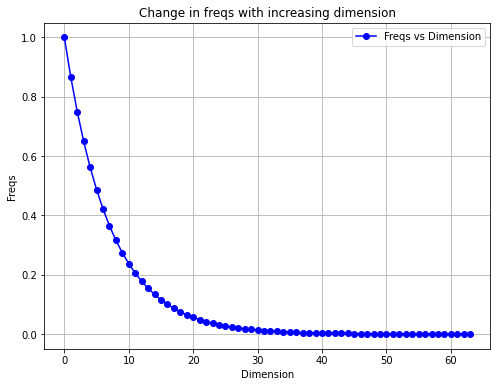

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
theta = 10000.0
dim = 128  # Example dimension size

# Calculate freqs as per the formula
freqs = 1.0 / (theta ** (np.arange(0, dim, 2)[: (dim // 2)] / dim))

# Plotting the freqs
plt.figure(figsize=(8, 6))
plt.plot(freqs, marker='o', linestyle='-', color='b', label='Freqs vs Dimension')
plt.title("Change in freqs with increasing dimension")
plt.xlabel("Dimension")
plt.ylabel("Freqs")
plt.grid(True)
plt.legend()
plt.show()

In [38]:
m = torch.arange(36, device=freqs.device)

In [39]:
m

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

In [40]:
freqs = 1/ (10000 ** (torch.arange(0, dim, 2)[: (dim // 2)].float() /dim))

freqs = torch.outer(m, freqs).float()

In [41]:
freqs

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 5.6234e-01, 3.1623e-01, 1.7783e-01, 1.0000e-01, 5.6234e-02,
         3.1623e-02, 1.7783e-02, 1.0000e-02, 5.6234e-03, 3.1623e-03, 1.7783e-03,
         1.0000e-03, 5.6234e-04, 3.1623e-04, 1.7783e-04],
        [2.0000e+00, 1.1247e+00, 6.3246e-01, 3.5566e-01, 2.0000e-01, 1.1247e-01,
         6.3246e-02, 3.5566e-02, 2.0000e-02, 1.1247e-02, 6.3246e-03, 3.5566e-03,
         2.0000e-03, 1.1247e-03, 6.3246e-04, 3.5566e-04],
        [3.0000e+00, 1.6870e+00, 9.4868e-01, 5.3348e-01, 3.0000e-01, 1.6870e-01,
         9.4868e-02, 5.3348e-02, 3.0000e-02, 1.6870e-02, 9.4868e-03, 5.3348e-03,
         3.0000e-03, 1.6870e-03, 9.4868e-04, 5.3348e-04],
        [4.0000e+00, 2.2494e+00, 1.2649e+00, 7.1131e-01, 4.0000e-01, 2.2494e-01,
         1.2649e-01, 7.1131e-02, 4.0000

In [43]:
precompute_pos_cis(dim=512, max_position = 128, theta=10000).shape
# (seq_len,d_model/2)

torch.Size([128, 256])

In [18]:
precompute_pos_cis(dim=512, max_position = 128, theta=10000)

tensor([[ 1.0000+0.0000e+00j,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
          ...,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
          1.0000+0.0000e+00j],
        [ 0.5403+8.4147e-01j,  0.5697+8.2186e-01j,  0.5974+8.0196e-01j,
          ...,  1.0000+1.1140e-04j,  1.0000+1.0746e-04j,
          1.0000+1.0366e-04j],
        [-0.4161+9.0930e-01j, -0.3509+9.3641e-01j, -0.2863+9.5814e-01j,
          ...,  1.0000+2.2279e-04j,  1.0000+2.1492e-04j,
          1.0000+2.0733e-04j],
        ...,
        [ 0.7877-6.1604e-01j,  0.3603+9.3283e-01j, -0.9966-8.2481e-02j,
          ...,  0.9999+1.3924e-02j,  0.9999+1.3432e-02j,
          0.9999+1.2958e-02j],
        [ 0.9440+3.2999e-01j, -0.5614+8.2756e-01j, -0.5292-8.4850e-01j,
          ...,  0.9999+1.4036e-02j,  0.9999+1.3540e-02j,
          0.9999+1.3061e-02j],
        [ 0.2324+9.7263e-01j, -0.9999+1.0082e-02j,  0.3643-9.3127e-01j,
          ...,  0.9999+1.4147e-02j,  0.9999+1.3647e-02j,
          0.9999+1.3165e-02j]])

- **polars是什么函数？为什么会出现复数结果？**

`torch.polar(abs, angle)` 是 PyTorch 中的一个函数，它将给定的模长（`abs`）和角度（`angle`）转换为复数形式。复数的表示方式如下：
$$ z = r \cdot e^{i \theta} $$
其中：
- $ z $ 是复数，
- $ r $ 是模长，
- $ \theta $是角度，
- $ i $ 是虚数单位。

`torch.polar(torch.ones_like(freqs), freqs)` 表示生成了复数，其模长为1，角度为 `freqs`。因此，`pos_cis` 包含的每个值都是单位模长的复数，且角度根据 `freqs`（频率）变化。复数在很多场景中用于表示角度旋转、周期性现象（如正弦波和余弦波）和信号处理。在频率编码中，通过使用复数的极坐标形式，便于对旋转的角度进行编码。如果你不想使用复数表示，可以考虑直接使用 `torch.sin()` 和 `torch.cos()` 来对频率进行编码。例如：

```python
# 直接使用 sin 和 cos 进行位置编码
pos_enc_sin = torch.sin(freqs)
pos_enc_cos = torch.cos(freqs)

# 合并 sin 和 cos 的编码
pos_enc = torch.cat([pos_enc_sin, pos_enc_cos], dim=-1)
```

这样你就可以避免使用复数，并且能够直接获得与传统位置编码相似的正弦和余弦形式。

- **旋转位置编码仅用于Q和K矩阵**

在 LLaMA 中，旋转位置编码（RoPE, Rotary Position Embedding）仅用于 **Q**（Query）和 **K**（Key）矩阵，而不应用于 **V**（Value）矩阵，这有特定的数学和功能性原因，主要与 **自注意力机制** 的工作原理以及相对位置信息的处理方式有关。

1. **QK 矩阵与相对位置编码的关联**：

在自注意力机制中，注意力权重通过计算 Query 和 Key 的点积来获得，具体公式为：
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$
其中 $ Q $ 是查询矩阵，$ K$ 是键矩阵，$ V $ 是值矩阵。

通过这种计算，**Query 和 Key 的点积决定了每个位置之间的相对相关性**。如果我们希望通过位置编码让模型意识到输入序列中元素的相对位置，那么只需将旋转位置编码应用于 **Q** 和 **K**，因为它们参与了点积计算，并直接影响注意力得分。

- **RoPE 为 QK 计算引入相对位置感知**：  
  RoPE 的旋转操作对 Q 和 K 矩阵的特征进行旋转变换，这会改变它们的内积结果，从而为模型注入了相对位置信息。这样，RoPE 能够在 QK 点积时，隐含地捕捉到输入序列中元素之间的相对位置关系。

2. **为什么不对 V（Value）矩阵应用 RoPE**：

- **V 矩阵的作用**：  
  Value 矩阵 $ V $ 不参与注意力权重的计算，而是用于对注意力权重加权后的特征进行值传递。换句话说，**V 矩阵携带的是特征信息**，而不是决定哪些特征与哪些位置相关联。

- **RoPE 的作用与相对位置无关**：  
  因为 RoPE 的主要作用是为 Q 和 K 的点积引入相对位置感知，而 V 矩阵只是根据计算出的注意力权重进行加权，没有必要加入位置信息。如果对 V 矩阵也应用 RoPE，反而会破坏其携带的原始特征信息，不利于最终的模型表现。

3. **RoPE 提供的相对位置感知**：
自注意力机制的重点在于位置之间的相对关系，而不是每个位置的绝对位置。RoPE 正是通过对 Q 和 K 矩阵进行旋转，将相对位置信息引入点积结果中。由于 V 矩阵不参与计算相似性，使用 RoPE 对其进行变换没有实际意义，反而会导致不必要的复杂性。

4. **计算复杂度和效率的考虑**：
自注意力机制的计算量主要集中在 QK 点积和注意力权重的计算上。如果对 V 矩阵也应用 RoPE，会增加额外的计算复杂度和参数量，而这些额外的操作并不会对模型的性能带来明显改善。因此，RoPE 只应用于 Q 和 K，有助于保持计算效率。

In [18]:
#将频率用于q、k矩阵
def apply_rotary_emb(xq, xk, pos_cis):
    def unite_shape(pos_cis, x):
        ndim = x.ndim
        assert 0 <= 1 < ndim
        print(pos_cis.shape)
        print(x.shape[1])
        print(x.shape[-1])
        assert pos_cis.shape == (x.shape[1], x.shape[-1])
        shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
        return pos_cis.view(*shape)

    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    pos_cis = unite_shape(pos_cis, xq_)
    xq_out = torch.view_as_real(xq_ * pos_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * pos_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

这个函数 `apply_rotary_emb` 用于在计算自注意力机制时将旋转嵌入（rotary embeddings）应用到查询（`q`）和键（`k`）矩阵上。这种旋转嵌入是通过将频率（`pos_cis`）与 `q` 和 `k` 矩阵相结合来实现的，目的是提升模型对位置信息的编码能力。以下是逐行注释：

```python
# 将频率（位置编码）应用于查询矩阵 q 和键矩阵 k
def apply_rotary_emb(xq, xk, pos_cis):
    # 内部函数：用于调整 pos_cis（位置编码）的形状，使其与输入张量 x 的形状匹配
    def unite_shape(pos_cis, x):
        # 注意这里输入的x是已经转变为复数的Q和K矩阵
        # 复数Q、K矩阵的维度与实数Q、K矩阵的维度有区别
        # 例如，当实数Q矩阵的结构为 (10,128,512) 时
        # 复数Q矩阵的结构为(10,128,256,2)，其中后两位代表复数的实部和虚部
        # 此时如果对Q矩阵取最后一维索引，会得到最后一个实部，也就是256
        # 获取输入张量的维度数量
        ndim = x.ndim
        # 确保输入张量的维度数是有效的
        assert 0 <= 1 < ndim
        # 确保 pos_cis 的形状与输入 x 的形状中的seq_len, d_model维度匹配
        assert pos_cis.shape == (x.shape[1], x.shape[-1])
        # 构造新的形状，除了第二维度和最后一维度之外，其他维度都设置为 1
        # 这是为了广播 pos_cis 以匹配输入 x 的形状
        shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
        # 调整 pos_cis 的形状为新的 shape
        return pos_cis.view(*shape)

    # 将查询张量 xq 的最后一个维度视为复数的一部分，形状变为 (*xq.shape[:-1], -1, 2)
    # 这意味着将最后一维度按 2 拆分，转换为复数表示（因为一个复数由实部和虚部组成）
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))

    # 对键张量 xk 做同样的处理，将其转换为复数形式
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))

    # 调整 pos_cis 的形状，使其与查询矩阵 xq_ 的形状匹配
    pos_cis = unite_shape(pos_cis, xq_)

    # 将旋转嵌入应用到查询矩阵，复数乘法会影响幅度和相位
    # 然后将复数结果转换回实数形式并将其展平（恢复到原来的维度结构）
    xq_out = torch.view_as_real(xq_ * pos_cis).flatten(3)

    # 对键矩阵做同样的操作，应用旋转嵌入
    xk_out = torch.view_as_real(xk_ * pos_cis).flatten(3)

    # 返回处理后的查询矩阵和键矩阵，且类型与输入张量相同
    return xq_out.type_as(xq), xk_out.type_as(xk)
```

- 总结：
1. **输入参数：**
   - `xq`: 查询矩阵，通常来自自注意力机制中的查询。
   - `xk`: 键矩阵，通常来自自注意力机制中的键。
   - `pos_cis`: 位置编码信息，通常是通过旋转嵌入（rotary embeddings）生成的。

2. **关键步骤：**
   - **`unite_shape`**: 调整 `pos_cis` 的形状，使其可以通过广播机制与 `xq` 和 `xk` 相乘。
   - **`torch.view_as_complex`**: 将查询矩阵 `xq` 和键矩阵 `xk` 的最后一维转换为复数表示（通过将最后一维分成实部和虚部）。
   - **复数乘法**：将复数表示的 `xq` 和 `xk` 分别与位置编码 `pos_cis` 进行复数乘法。复数乘法会同时影响向量的幅度和相位（实现位置编码的效果）。
   - **`torch.view_as_real`**: 将复数乘法的结果转换回实数形式，并将结果展平为原来的形状。
   - **`flatten(3)`**: 展平最后两个维度，使得张量形状回归到与输入相同的结构。

3. **返回：**
   - 返回应用了旋转嵌入的查询矩阵和键矩阵。

- **为什么不直接使用正余弦位置编码？旋转位置编码有什么好处？**

1. **相对位置信息的编码**：与传统的正余弦编码主要侧重于绝对位置不同，RoPE能够自然地融入**相对位置信息**。这使得模型可以更好地理解序列中各个词之间的相对关系，对于那些词与词之间距离影响其关联性的任务尤为重要。RoPE通过在注意力机制中旋转查询和键向量，并且随着词之间距离的增加，它们的内积逐渐减弱，这有助于更好地模拟自然语言中远距离词语关联度降低的现象。

**正余弦位置编码**（Positional Encoding）的确利用了周期性函数（如正弦和余弦）来表示位置信息，其基本原理是通过不同频率的正弦和余弦函数来为每个位置分配一个独特的向量。这个向量的不同维度对不同频率进行编码，从而使得每个位置都有一个唯一的编码值，因此正余弦编码虽然是周期性的，但**它本质上是绝对位置编码**，因为它依赖于位置的绝对值。也就是说，它为每个特定的位置生成一个固定的编码，而不考虑其他位置。例如，序列中的第5个词和第10个词，即使它们距离很近或很远，它们的编码值只取决于它们在序列中的具体位置（即位置5和位置10），而不是它们之间的相对距离。相比之下，旋转位置编码（RoPE）将关注点放在相对位置上。它通过在自注意力机制中旋转查询和键向量，使得随着两个词之间距离的增加，它们的点积逐渐衰减，从而在模型中直接融入相对位置信息。这样，旋转位置编码可以更好地处理序列中相对距离的变化，而正余弦编码则更专注于词语的绝对位置。

2. **对序列长度的适应性**：旋转位置编码在序列长度上具有很高的灵活性。传统的正余弦编码在处理超出训练时序列长度的情况下，性能往往会下降，而RoPE可以轻松扩展到不同的序列长度，且性能下降较小。这是因为旋转过程不依赖于固定的长度，能够在不同长度的序列中保持有效性。

3. **高效且乘法式的编码方式**：RoPE使用乘法方法，而不是传统位置编码中的加法方法。这种方式可以在为模型提供位置上下文的同时，保留更多原始词嵌入的信息。此外，旋转的性质在结合线性注意力机制时能保证稳定性和计算效率，使RoPE在某些大规模模型中成为一种更为高效的选择。

总的来说，RoPE的优势在于其对相对位置的编码能力以及对不同长度序列的适应性，使其成为在LLaMA等基于Transformer架构中的一种强大且灵活的替代方案。

## 4. LLaMA中的注意力机制与kv缓存

**KV缓存（Key-Value Cache）**机制在Transformer模型的自回归生成任务中（如文本生成）是一种重要的加速技术，尤其是在处理长序列时。它能够减少重复计算，从而加速推理过程。这种机制主要应用于**解码器**架构，常见于GPT系列模型等自回归模型。在自回归生成任务中，模型逐步生成序列中的每个token。例如，在文本生成中，每一步生成一个新的token，然后将这个token与之前的所有tokens一起重新输入模型，预测下一个token。对于每一步的生成，模型会重新计算所有tokens的注意力（self-attention），包括所有历史tokens（即已经生成的tokens）和当前生成的token。

在Transformer的每一层中，注意力机制会基于输入生成**查询（Query）**、**键（Key）**和**值（Value）**。计算公式如下：

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$

- `Query` 表示当前token的信息，它用于寻找与其他tokens相关的内容。
- `Key` 和 `Value` 分别代表历史tokens的信息，它们在每个生成步骤中被重新计算。

这种重新计算会导致计算量成倍增加。例如，如果生成了100个token，每一步都会重新计算前面99个token和当前token的注意力，这样的重复计算是非常耗时的。**KV缓存机制**的核心思想是避免重复计算注意力层（self-attention）中的键（Key）和值（Value）。KV缓存通过将生成过程中每个token的Key和Value保存在缓存中，只在第一次生成时计算一次Key和Value。在生成后续token时，模型只需要计算新token的Query，而可以直接使用缓存中已经存储的Key和Value，避免了对历史tokens的重复计算。

- **工作原理**

以下是KV缓存机制的详细工作原理。注意，**KV缓存大部分时候适用于推理，因此这个流程大部分时候是自回归的**。

1. **初始化**：
   - 当生成开始时，模型计算输入序列的Key和Value，并将这些计算结果缓存起来，保存在内存中。
     
   - **大部分时候，每个注意力层都会有一对Key-Value缓存，这个缓存是在自回归的每次循环中共用。然而，有时我们也可以在多头注意力机制中、只保留一个头或两个头上的KV值，并共享给所有的头使用**。其中，每次循环中的kv缓存，是推理中常见的用法。多头共享kv的缓存，可以被用于训练和推理两个流程，但可能伤害训练的结果。
     
   - 这些缓存的Key和Value会存储到KV缓存中，并作为后续生成步骤中的参考。

2. **生成过程中**：
   - 当生成下一个token时，模型不需要重新计算前面已经生成的token的Key和Value。它会直接使用之前缓存的Key和Value。
   - 只需要计算当前token的Query，并将它与已经缓存的Key进行点积计算，得出注意力分数。
   - 这些注意力分数会结合缓存的Value来计算当前token的输出。

3. **更新缓存**：
   - 对于每一个生成步骤，模型还会将当前生成的token的Key和Value加入缓存，确保缓存中的Key和Value始终保持更新，包含所有已经生成的tokens。
   - 缓存的大小会逐渐增加，最终会包含所有生成序列的Key和Value。

4. **加速效果**：
   - 由于每个生成步骤只需要计算当前token的Query，而不需要重新计算整个序列的Key和Value，这大大减少了计算量。
   - 随着序列长度增加，缓存的使用能够显著减少时间复杂度，使生成过程更快。

- **实现代码**

In [32]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )

代码解读——

In [45]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    # 定义函数 repeat_kv，接受两个参数：张量 x 和重复次数 n_rep
    # x 是一个形状为 (bs, slen, n_kv_heads, head_dim) 的张量，分别代表：
    # bs: 批次大小 (batch size)
    # slen: 序列长度 (sequence length)
    # n_kv_heads: KV 头的数量 (number of key-value heads)
    # head_dim: 每个头的维度大小 (dimension size of each head)
    # n_rep: 重复次数

    # 获取张量的形状 (bs: 批次大小, slen: 序列长度, n_kv_heads: KV 头的数量, head_dim: 每个头的维度)
    bs, slen, n_kv_heads, head_dim = x.shape

    # 如果 n_rep 为 1，表示不需要重复，直接返回原始张量
    if n_rep == 1:
        return x

    # 执行以下操作以重复 KV 头：
    # 1. 在第 4 维度 (即 None) 上扩展 x，使其形状为 (bs, slen, n_kv_heads, 1, head_dim)
    # 2. 使用 expand 函数将第 4 维度扩展为 n_rep，得到形状 (bs, slen, n_kv_heads, n_rep, head_dim)
    # 3. 最后通过 reshape 将形状重新调整为 (bs, slen, n_kv_heads * n_rep, head_dim)
    # 这会将每个 KV 头重复 n_rep 次
    return (
        x[:, :, :, None, :]                       # 扩展张量，在 n_kv_heads 后增加一个维度
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)  # 扩展 n_rep 次
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)  # 调整形状为新的维度
    )

<font color="red">**根据我们的解读，不难看出，这一段代码是允许多头注意力机制的多个头共享kv缓存的代码。如果要让每个头都拥有自己独特的k和v，只在推理过程中每个循环中进行缓存，那只要让n_rep=1即可。**</font>

- KV缓存的优点

1. **提高生成速度**：由于避免了对已经生成token的重复计算，KV缓存机制可以显著减少生成时间，特别是在长序列生成任务中。
   
2. **节省计算资源**：缓存Key和Value后，每一步生成仅需计算当前token的Query，而Key和Value可以从缓存中提取，从而大幅减少每一步的计算量。

3. **降低复杂度**：使用缓存后，生成过程中的注意力机制从 O(n²) 降为 O(n)，其中 n 是序列长度。对于长序列生成任务，这种加速效果尤为显著。

- KV缓存与DeepSpeed和Hugging Face的结合

> - **DeepSpeed**：KV缓存在DeepSpeed等加速框架中发挥更大作用，DeepSpeed可以进一步优化KV缓存的使用，利用其高效的并行和内存管理机制，进一步提升生成过程中的性能。<br><br>
> - **Hugging Face**：Hugging Face的模型可以直接支持KV缓存，特别是其`generate`函数可以通过指定`kv_cache=True`来启用KV缓存，优化推理和生成过程。

In [11]:
#在运行Attention之前，你首先需要设置好配置文件LMConfig
#我们所有的参数都从LMConfig里面导入

In [206]:
class Attention(nn.Module):
    def __init__(self, args: LMConfig):
        super().__init__()

        # 先确定n_kv_heads的值，如果设置了单独的n_kv_heads，就执行多头共享机制
        # 如果没设置kv_heads，就意味着全部的头都要执行kv缓存，此时n_kv_heads = n_heads
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads

        # 检验，n_heads能否被n_kv_heads除尽
        assert args.n_heads % self.n_kv_heads == 0

        # 设置头数、kv缓存头数和重复次数
        self.n_local_heads = args.n_heads
        self.n_local_kv_heads = self.n_kv_heads
        self.n_rep = self.n_local_heads // self.n_local_kv_heads

        # 设置每个头上的特征维度
        self.head_dim = args.dim // args.n_heads

        # 设置权重层，当 x 的结构为 (seq_len, d_model)时
        # 常规的Q、K、V矩阵的结构应该与 X 一致，也是 (seq_len, d_model)
        # 因此常规的 w 应该是 (d_model,d_model)结构
        # 在多头注意力中，w 应该是 (d_model, d_model/n_heads)
        # 在具有kv缓存的情况下，我们是对所有头上的注意力并行计算
        # 因此Q的权重应该是(d_model, d_model)
        # K和V的权重应该是(d_model, d_model/n_heads * n_kv_heads)
        self.wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)

        # 输出层上的O的权重不受影响，是(d_model, d_model)
        self.wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False)

        # 设置kv缓存初始值
        self.k_cache, self.v_cache = None, None

        # 设置注意力和残差连接上的dropout层和dropout比例
        self.attn_dropout = nn.Dropout(args.dropout)
        self.resid_dropout = nn.Dropout(args.dropout)
        self.dropout = args.dropout

        # flash attention
        # print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention') and args.flash_attn

        # 设置decoder专用前瞻掩码
        # 注意，前瞻掩码是用于QK.T矩阵的
        mask = torch.full((1, 1, args.max_seq_len, args.max_seq_len), float("-inf"))
        mask = torch.triu(mask, diagonal=1)

        # buffer用于保存神经网络中除了权重之外、需要被保存的静态数据们
        # 比如掩码矩阵、比如位置编码中的频率等等编码表
        # "mask"我们指定的buffer名称，我们可以通过self.mask来调出掩码矩阵
        self.register_buffer("mask", mask, persistent=False)

    # 设置旋转位置编码中的频率计算
    def _precompute_pos_cis(self, dim: int, max_position = 10000, theta: float = 10000.0):
        freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
        m = torch.arange(max_position, device=freqs.device)
        freqs = torch.outer(m, freqs).float()
        pos_cis = torch.polar(torch.ones_like(freqs), freqs)
        return pos_cis
    
    def forward(self, x: torch.Tensor, kv_cache=False):

        # 作为注意力机制，被输入的x就是原始数据x
        # 结构为 (bs, seq_len, d_model)
        bsz, seqlen, _ = x.shape

        # 无论是否执行KV缓存，Q的求解是不变的
        xq = self.wq(x)

        # 如果是训练模式下，K和V照常求解
        if self.train():
            # 将x输入线性层、转换为初始的K和V
            # 但是只需要n_kv_heads个头的部分
            xk, xv = self.wk(x), self.wv(x)

        # 如果是推理模式，且kv_cache设置是打开的
        # 那要判断现在是否是初次预测
        if kv_cache and self.eval():
            # kv缓存是否还是None？已经存在了吗？
            if all(cache is not None for cache in (self.k_cache, self.v_cache)):
                # 如果不是None，说明不是初次预测了，此时需要的是缓存更新
                xk_new_token = self.wk(x[:,-1,:]).unsqueeze(1)
                xv_new_token = self.wv(x[:,-1,:]).unsqueeze(1)
                xk = torch.cat((self.k_cache, xk_new_token), dim=1)
                xv = torch.cat((self.v_cache, xv_new_token), dim=1)
            else:
                # 如果k和v缓存中有一个为None，说明是初次预测
                xk, xv = self.wk(x), self.wv(x)
            #生成xk和xv后，把结果保存到缓存中
            self.k_cache, self.v_cache = xk, xv

        # 为了更省内存，我们要将数据结构重新整理后适应位置编码的结构
        # 可以将该流程命名为“多头旋转位置编码”
        xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)

        # 在Q和K上执行旋转位置编码
        pos_cis = self._precompute_pos_cis(self.head_dim, seqlen)
        xq, xk = apply_rotary_emb(xq, xk, pos_cis)

        # 将k矩阵和v矩阵进行重复
        xk = repeat_kv(xk, self.n_rep)  # (bs, seqlen, n_local_heads, head_dim)
        xv = repeat_kv(xv, self.n_rep)  # (bs, seqlen, n_local_heads, head_dim)

        # 矩阵乘法计算注意力分数时，要将n_heads作为第二维度
        # 因为实际要进行乘法的应该时 (seqlen, head_dim) 这样的二维表
        # transpose交换维度，结构变为(bs, n_local_heads, seqlen, head_dim)
        xq = xq.transpose(1, 2)
        xk = xk.transpose(1, 2)
        xv = xv.transpose(1, 2)

        # 如果使用flash attention的话
        # 就调用nn.functional下面的点乘注意力计算方法
        if self.flash and seqlen != 1:
            output = torch.nn.functional.scaled_dot_product_attention(xq, xk, xv
                                                                      , attn_mask=None #这里是padding掩码
                                                                      , dropout_p=self.dropout if self.training else 0.0
                                                                      , is_causal=True #这里是自动化的前瞻掩码
                                                                     )
        else:
            # 不使用flash attention，就自己计算
            # 这里的transpose是对最后两个维度的转置
            scores = torch.matmul(xq, xk.transpose(2, 3)) / math.sqrt(self.head_dim)
            
            # 在注意力分数上放上掩码
            # 如果有kv缓存的话，现在我们的kv矩阵可能会比掩码矩阵要大了
            # 获取缓存的长度
            cache_len = self.k_cache.shape[1] if self.k_cache is not None else 0
            total_len = cache_len + 1  # 当前总长度，等于历史缓存长度 + 当前序列长度

            # 检查是否需要扩展掩码矩阵
            if total_len > self.mask.shape[-1]:
                # 动态生成新的掩码，大小为 (seq_len + cache_len, seq_len + cache_len)
                new_mask = torch.full((1, 1, total_len, total_len), float("-inf")).to(x.device)
                new_mask = torch.triu(new_mask, diagonal=1)  # 生成前瞻掩码
                self.mask = new_mask  # 更新掩码矩阵
            
            scores = scores + self.mask[:, :, :seqlen, :seqlen]
                
            # 对最后一个维度求解softmax
            scores = F.softmax(scores.float(), dim=-1).type_as(xq)
            scores = self.attn_dropout(scores)
            output = torch.matmul(scores, xv)  # (bs, n_local_heads, seqlen, head_dim)

        # 最后再将结构转回来，并且将n_heads中的所有信息合并
        # contiguous() 用于确保张量在内存中的存储是连续的
        # 特别是在经过某些操作（如 transpose）后，这对后续的 view() 等操作至关重要，以避免错误
        output = output.transpose(1, 2).contiguous().view(bsz, seqlen, -1)

        # 注意力机制的输出
        output = self.wo(output)
        output = self.resid_dropout(output)
        return output

- 模型验证

In [220]:
import torch
import torch.nn as nn

# 假定的配置类
class LMConfig_:
    def __init__(self, n_heads=8, n_kv_heads=2, dim=512, max_seq_len=10000, dropout=0.1, flash_attn=False):
        self.n_heads = n_heads  # 注意力头的数量
        self.n_kv_heads = n_kv_heads  # KV共享头的数量
        self.dim = dim  # 模型的维度
        self.max_seq_len = max_seq_len  # 最大序列长度
        self.dropout = dropout  # dropout比例
        self.flash_attn = flash_attn  # 是否使用flash attention

# Attention类的测试实例化
args_ = LMConfig_()

# 重复kv
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )

#将频率用于q、k矩阵
def apply_rotary_emb(xq, xk, pos_cis):
    def unite_shape(pos_cis, x):
        ndim = x.ndim
        assert 0 <= 1 < ndim
        assert pos_cis.shape == (x.shape[1], x.shape[-1])
        shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
        return pos_cis.view(*shape)

    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    pos_cis = unite_shape(pos_cis, xq_)
    xq_out = torch.view_as_real(xq_ * pos_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * pos_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

In [221]:
# 创建假设输入
x = torch.randn(2, 10, 512)  # (batch_size=2, seq_len=10, dim=512)
pos_cis = precompute_pos_cis(dim=64, max_position = 10, theta=10000)

In [222]:
# 创建Attention实例
attention = Attention(args_)

# 前向传播
output = attention(x,kv_cache=True)
output.shape

torch.Size([2, 10, 512])

- **验证是否开启kv缓存会带来的运算速度变化**

In [223]:
import time

# 定义计时函数
def measure_inference_time(attention, x, kv_cache):
    start_time = time.time()
    output = attention(x, kv_cache=kv_cache)
    end_time = time.time()
    return end_time - start_time

In [224]:
# 创建假设输入
x = torch.randn(2, 100, 512)  # (batch_size=2, seq_len=100, dim=512)
head_dim = int(512/8)

# 创建Attention实例
attention = Attention(args_)

# 测试关闭kv_cache的推理时间
time_without_cache = measure_inference_time(attention, x, kv_cache=False)
print(f"推理时间（关闭kv_cache）: {time_without_cache:.6f} 秒")

推理时间（关闭kv_cache）: 0.006324 秒


In [226]:
# 模拟逐步生成的推理输入（关闭kv_cache）
x = torch.randn(2, 200, 512)
x_new_token = torch.randn(2, 1, 512)  # 模拟单个新生成的token
attention.k_cache = None  # 清空KV缓存
head_dim = int(512/8)

# 运行并计时
time_with_cache = 0.0
for i in range(1000):  # 模拟生成1000个token的过程
    x = torch.cat((x, x_new_token), dim=1)
    time_with_cache += measure_inference_time(attention, x, kv_cache=False)

print(f"推理时间（开启kv_cache）: {time_with_cache:.6f} 秒")

推理时间（开启kv_cache）: 78.550040 秒


In [227]:
# 模拟逐步生成的推理输入（开启kv_cache）
x = torch.randn(2, 200, 512)
x_new_token = torch.randn(2, 1, 512)  # 模拟单个新生成的token
attention.k_cache = None  # 清空KV缓存
head_dim = int(512/8)

# 运行并计时
time_with_cache = 0.0
for i in range(1000):  # 模拟生成100个token的过程
    x = torch.cat((x, x_new_token), dim=1)
    time_with_cache += measure_inference_time(attention, x, kv_cache=True)

print(f"推理时间（开启kv_cache）: {time_with_cache:.6f} 秒")

推理时间（开启kv_cache）: 58.885653 秒


## 5. 门控前馈神经网络FFN with SwiGLU

与常见的前馈神经网络相比，Llama中的前馈神经网络有一些独特的设计。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/15.png)

> **典型前馈网络**：
$$
  \text{Output} = \text{Linear2}(\text{Activation}(\text{Linear1}(x)))
$$
  它通过一个线性层（`Linear1`），一个非线性激活函数（如ReLU或GELU），然后通过另一个线性层（`Linear2`）。

> **llama中的前馈神经网络**
$$
\text{Output} = \text{Linear2}
\left( \textcolor{red}{\text{Activation}}\left( \textcolor{green}{\text{Linear1}}(x) \right) 
\odot \textcolor{gold}{\text{Linear3}}(x) \right)
$$
  它通过两个线性层（`Linear1`和`Linear3`），从`Linear1`输出的结果经过silu激活函数后，与`Linear3`输出的结果进行逐元素乘法，然后通过另一个线性层（`Linear2`）。

为什么llama要做这样的修改呢？为了要了解这个前馈网络的机制，我们先要了解一下SwiGLU激活函数。

- **SwiGLU（Switch-Gated Linear Unit）门控线性单元激活函数**

**SwiGLU** 是一种新型的激活函数，由 **Shazeer (2020)** 在论文 *“Gated Linear Units for Efficient and Scalable Deep Learning”* 中提出。它被用在 **深度学习模型的前馈神经网络（FFN）层**中，如 **LLaMA**、**GPT-3** 和其他大型 Transformer 模型中。SwiGLU 的设计核心是基于**门控机制（gating mechanism）**，它通过引入两个线性路径的输出，并结合逐元素乘法，实现了对信息的动态控制。这种门控结构类似于在 LSTM 和 GRU 等门控循环网络中的思想，但它被应用在 Transformer 的前馈网络（FFN）层中，用于增强网络的非线性表达能力和训练效率。

SwiGLU 激活函数的基本形式如下：

$$
\text{SwiGLU}(x) = \textcolor{red}{\text{GELU}}\left( \textcolor{green}{W_1^a} \cdot x \right) 
\odot \textcolor{gold}{W_1^b} \cdot x
$$

其中：
- $W_1^a$ 和 $W_1^b$ 是线性变换（全连接层）。
- $\odot$ 表示 **逐元素乘法**（element-wise multiplication）。
- **GELU**（Gaussian Error Linear Unit）是一个非线性激活函数，它与ReLU激活函数类似，但它比 ReLU 更平滑，适用于深度模型。

| **特性**           | **ReLU**                        | **GELU**                      | **SwiGLU with GELU**                    |
|--------------------|---------------------------------|--------------------------------|--------------------------------|
| **表达能力**       | 线性激活，易丢失负值信息         | 平滑激活，但无门控机制         | 动态门控，表达能力最强         |
| **梯度流动**       | 负值梯度为 0，可能导致死神经元   | 平滑梯度流动                   | 更平滑的梯度流动，训练更稳定   |
| **训练效率**       | 计算简单，但可能不稳定           | 计算稍复杂，但效果更好         | 高效计算，适合大规模模型       |

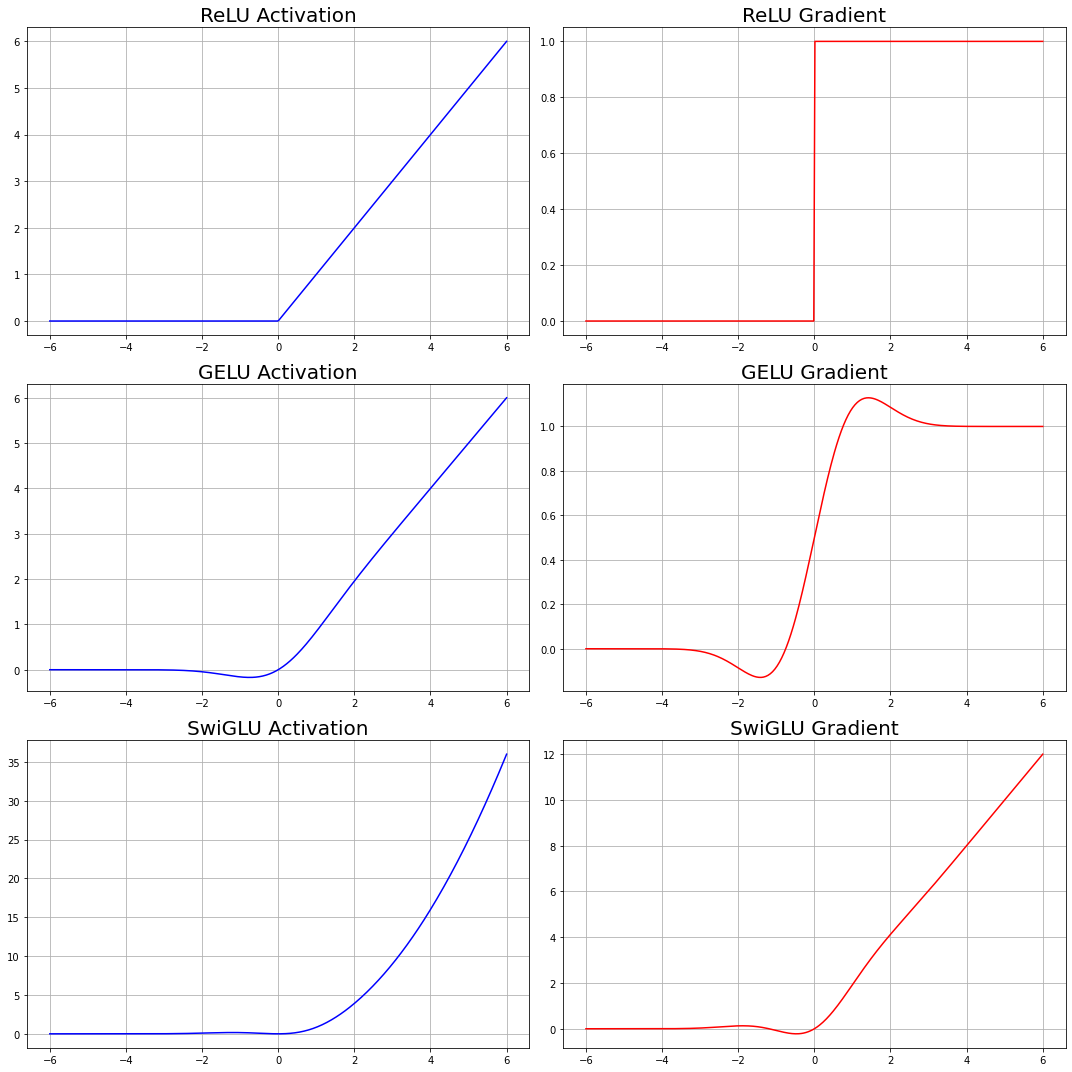

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 ReLU 激活函数及其梯度
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# 定义 GELU 激活函数及其梯度
def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

def gelu_derivative(x):
    tanh_term = np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3))
    sech2_term = 1 - tanh_term ** 2  # tanh 导数
    return 0.5 * (1 + tanh_term + np.sqrt(2 / np.pi) * x * (1 + 3 * 0.044715 * x**2) * sech2_term)

# 定义 SwiGLU 激活函数及其梯度
def swiglu(x, W1a=1.0, W1b=1.0):
    return gelu(W1a * x) * (W1b * x)

def swiglu_derivative(x, W1a=1.0, W1b=1.0):
    gelu_grad = gelu_derivative(W1a * x) * W1a
    return gelu_grad * (W1b * x) + gelu(W1a * x) * W1b

# 创建输入数据
x = np.linspace(-6, 6, 400)

# 计算所有函数及其梯度
y_relu, y_relu_grad = relu(x), relu_derivative(x)
y_gelu, y_gelu_grad = gelu(x), gelu_derivative(x)
y_swiglu, y_swiglu_grad = swiglu(x), swiglu_derivative(x)

# 绘制 3x2 图像布局
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# ReLU 激活函数和梯度
axes[0, 0].plot(x, y_relu, color='b', label='ReLU')
axes[0, 0].set_title('ReLU Activation',size=20)
axes[0, 0].grid(True)
axes[0, 1].plot(x, y_relu_grad, color='r', label='ReLU Gradient')
axes[0, 1].set_title('ReLU Gradient',size=20)
axes[0, 1].grid(True)

# GELU 激活函数和梯度
axes[1, 0].plot(x, y_gelu, color='b', label='GELU')
axes[1, 0].set_title('GELU Activation',size=20)
axes[1, 0].grid(True)
axes[1, 1].plot(x, y_gelu_grad, color='r', label='GELU Gradient')
axes[1, 1].set_title('GELU Gradient',size=20)
axes[1, 1].grid(True)

# SwiGLU 激活函数和梯度
axes[2, 0].plot(x, y_swiglu, color='b', label='SwiGLU')
axes[2, 0].set_title('SwiGLU Activation',size=20)
axes[2, 0].grid(True)
axes[2, 1].plot(x, y_swiglu_grad, color='r', label='SwiGLU Gradient')
axes[2, 1].set_title('SwiGLU Gradient',size=20)
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

- <font color="red">**门控机制为什么高效**？

门控机制（Gating Mechanism）是深度学习中的一种重要设计，它通过动态选择信息流，提升模型的表达能力和训练效率。相比于单纯的线性变换和激活函数，门控机制更灵活，使模型能够根据输入数据的特性决定哪些信息需要传递、哪些信息需要抑制。

| **优势**                   | **解释**                                              |
|----------------------------|-------------------------------------------------------|
| **避免冗余计算**           | 只让有用的信息通过，抑制无关信息，提升计算效率。       |
| **强化非线性表达能力**     | 通过多条路径组合增强模型的表达能力。                   |
| **改善梯度流动**           | 减少梯度消失问题，提高深层网络的训练效率。             |
| **自适应学习能力**         | 根据不同输入动态选择信息流，提高任务适应性。            |
| **多任务场景中的共享能力** | 在多任务或多模态模型中更智能地控制信息流动路径。         |

**总结**：门控机制通过**逐元素乘法和动态调控**，使模型能够高效选择性地传递信息，避免了简单线性流程中的冗余计算和信息丢失问题。相比于传统的线性层，门控机制不仅**提高了计算效率**，还增强了模型的**非线性表达能力**和**训练稳定性**，使其在 NLP 和计算机视觉等复杂任务中表现更加优异。

这一函数非常好地展现了门控机制的精髓！受到SwiGLU激活函数的思路影响，LLaMA重新设计了前馈神经网络架构，为原本嵌套的线性层加入了“门控”的逻辑，并且结合了这种逻辑的前馈网络称之为**FFN with SwiGLU**，我将之译为门控前馈神经网络。

<center><img src="https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/06.png" alt="描述文字" width="400">

不过，在实际实现LLaMA架构的时候，LLaMA官方却没有用广受好评的GELU函数，而是使用了SILU激活函数。**SiLU** 是一种平滑的非线性激活函数，全称为 **Sigmoid-Weighted Linear Unit**。它是由 **Sigmoid 函数**与输入的乘积构成的激活函数，具有较好的梯度流动特性，常用于深度神经网络的激活层中。**SiLU** 在许多深度学习任务中表现优于传统的激活函数（如 ReLU），并且已经被应用在 **Transformer** 等现代架构中（例如，EfficientNet 以及一些 NLP 模型）。

$$
\text{SiLU}(x) = x \cdot \sigma(x)
$$

其中：
- $x$ 是输入值。
- $\sigma(x)$ 是 **Sigmoid** 函数：
  $$
  \sigma(x) = \frac{1}{1 + e^{-x}}
  $$

SiLU 的输出是输入 $x$ 和 Sigmoid 函数 $\sigma(x)$ 的逐元素乘积。

**SiLU 的导数（梯度）计算如下**：

$$
\frac{d}{dx} \text{SiLU}(x) = \sigma(x) + x \cdot \sigma(x) \cdot (1 - \sigma(x))
$$

其函数图像与梯度图像如下👇

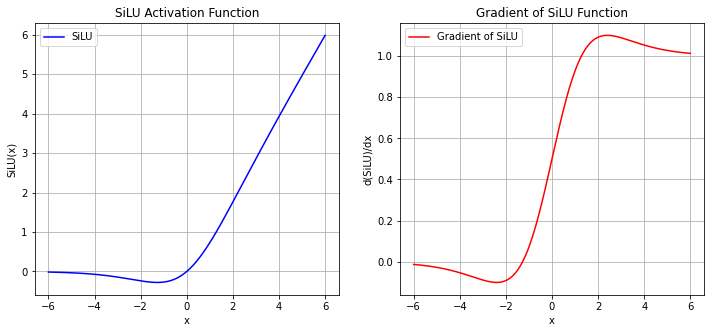

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 SiLU 激活函数及其梯度
def silu(x):
    return x * (1 / (1 + np.exp(-x)))  # SiLU = x * sigmoid(x)

def silu_derivative(x):
    sigmoid_x = 1 / (1 + np.exp(-x))
    return sigmoid_x * (1 + x * (1 - sigmoid_x))  # d(SiLU)/dx

# 创建输入数据
x = np.linspace(-6, 6, 400)

# 计算 SiLU 和其梯度
y_silu = silu(x)
y_silu_grad = silu_derivative(x)

# 绘制 SiLU 激活函数及其梯度
plt.figure(figsize=(12, 5))

# SiLU 激活函数图像
plt.subplot(1, 2, 1)
plt.plot(x, y_silu, label='SiLU', color='b')
plt.title('SiLU Activation Function')
plt.xlabel('x')
plt.ylabel('SiLU(x)')
plt.grid(True)
plt.legend()

# SiLU 梯度图像
plt.subplot(1, 2, 2)
plt.plot(x, y_silu_grad, label='Gradient of SiLU', color='r')
plt.title('Gradient of SiLU Function')
plt.xlabel('x')
plt.ylabel('d(SiLU)/dx')
plt.grid(True)
plt.legend()

plt.show()

这样的结构被发现非常适应深度神经网络、尤其是Transformer结构，总结一下SiLU激活函数有如下的优点👇

1. **更好的梯度流动**：SiLU 在负值区域不会完全输出 0，因此减少了梯度消失和死神经元问题。
<br><br>
2. **平滑激活**：由于 SiLU 是平滑的，它在训练过程中提供了更平稳的梯度更新，使模型更容易收敛。
<br><br>
3. **自适应线性和非线性**：对于较大的正值输入，SiLU 的输出接近于线性；而对较小的负值输入，它会进行压缩处理。这种自适应特性增强了模型对复杂模式的捕捉能力。
<br><br>
4. **计算效率高**：SiLU 的计算复杂度适中，且在现代 GPU/TPU 上的计算效率非常高。

| **特性**        | **ReLU**                       | **GELU**                     | **SiLU**                      |
|-----------------|--------------------------------|------------------------------|-------------------------------|
| **平滑性**      | 不平滑                         | 平滑                         | 平滑                          |
| **负值处理**    | 输出 0                         | 有负值输出                    | 更加平滑的负值输出                    |
| **梯度流动**    | 负值区域无梯度                 | 平滑梯度流动                 | 全范围平滑梯度流动            |
| **表达能力**    | 适中                           | 强                           | 强，且自适应线性/非线性       |
| **计算复杂度**  | 低                             | 较高                         | 适中                          |


因此在LLaMA的前馈神经网络中我们实现的实际上是——

> **SwiGLU with Silu**
$$
\text{Output} = \text{Linear2}
\left( \textcolor{red}{\text{Silu}}\left( \textcolor{green}{\text{Linear1}}(x) \right) 
\odot \textcolor{gold}{\text{Linear3}}(x) \right)
$$

In [53]:
class FeedForward(nn.Module):
    def __init__(self, dim: int, hidden_dim: int, multiple_of: int, dropout: float):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = 4 * dim
            hidden_dim = int(2 * hidden_dim / 3)
            hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.w2(F.silu(self.w1(x)) * self.w3(x)))

- hidden_dim的系列计算是什么？

```python
if hidden_dim is None:
    hidden_dim = 4 * dim  # Step 1: 设置初始值，通常为输入维度的 4 倍
    hidden_dim = int(2 * hidden_dim / 3)  # Step 2: 缩减到 2/3 的大小
    hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)  # Step 3: 对齐 multiple_of
```

这三步的设置逻辑如下：
1. **Step 1**：`hidden_dim = 4 * dim`  
> 这是常见的做法，类似于 **Transformer** 的前馈网络中使用的隐藏维度。将隐藏层设为输入维度的 4 倍，可以增强网络的非线性表达能力。

2. **Step 2**：`hidden_dim = int(2 * hidden_dim / 3)` 
> 这里缩小了隐藏维度，将其减少到 **原值的 2/3**。这一步背后的原因通常是为了**平衡计算开销和模型容量**。隐藏层的维度直接决定了模型的参数量和计算开销。如果按照传统做法设置为 **4 倍的输入维度**，模型可能在某些任务中变得过大，训练和推理的时间复杂度较高。缩减到 2/3，可以**减少 1/3 的参数量**和计算成本，这对于大模型或资源受限的设备非常重要。在一些现代 Transformer 模型（例如 LLaMA）中，缩减隐藏层维度是一种经验优化。研究表明，减少隐藏维度（例如从 $4 \cdot d$ 缩减到 $\frac{8}{3} \cdot d$）往往能在**模型性能和效率之间取得良好平衡**。

3. **Step 3**：`hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)`  
> 这一步确保隐藏维度是 **multiple_of** 的倍数，以优化 GPU 计算效率。

- multiple_of是什么？

在FFN实际实现的过程中，multiple_of是我们用来控制hidden_dim大小的关键参数，它代表“你想要让你的hidden_dim能整除某个数吗？”

In [28]:
int(2* (4 * 512) / 3)

1365

In [32]:
multiple_of = 4

In [33]:
multiple_of * ((1365 + multiple_of-1) // multiple_of)

1368

In [31]:
1368//4

342

## 7. 混合专家网络用于FFN层

还记得门控机制是如何操作的吗？当我们在SwiGLU激活函数中，使用一个线性层的输出结果来乘以另一个线性层的结果时，我们把其中一个线性层看作携带信息的层，把另一个线性层看作“门控机制”，以此来压缩数据的通路、逼迫模型筛选出更精准、更重要的信息。

$$
\text{SwiGLU}(x) = \textcolor{red}{\text{GELU}}\left( \textcolor{green}{W_1^a} \cdot x \right) 
\odot \textcolor{gold}{W_1^b} \cdot x
$$

从门控机制出发我们可以设想，**如果我们不止一扇门呢？这是否意味着我们可以拥有动态的筛选策略？是否意味着我们可以同时筛选出不同、但都非常重要和精准的信息**？就如同卷积神经网络利用不同的卷积核解读不同的信息、注意力机制用不同的头来解读不同的信息一样，门控机制中我们也可以有不同的门来用不同的方式筛选信息，**混合专家模型**因此而诞生，让我们来看看混合专家模型——

<center><img src="https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/16.png" alt="描述文字" width="400">

当我们使用多个门同时控制信息的流通时，这些多个门构成的结构被称为是**路由器**。如图所示，**混合专家模型 (MoE)** 是一种**动态路由**策略，通过为不同的输入选择不同的子模型（专家模型）进行计算。相比于传统的全连接前馈网络（FFN），MoE 在每次前向传播时只激活部分专家模型，从而实现**参数高效**和**计算高效**。动态路由策略是一种在深度学习模型中使用的技术，其核心思想是：根据输入数据的特征动态地选择路径或专家模型来处理信息。与传统模型固定的前向传播路径不同，动态路由策略在每次前向传播时，根据输入的情况选择最合适的子网络、路径或专家来处理数据。这大幅提升了模型的灵活性、计算效率和泛化能力。

MoE 已经广泛应用于大规模自然语言处理模型（如 GShard、Switch Transformer 等），并在计算机视觉等领域表现出色。其核心优势在于：**模型具有超大参数量**，但每次推理或训练时，只使用部分参数来进行计算。

- **MoE 的核心公式：**
$$
\text{Output} = \sum_{i=1}^N G_i(x) \cdot E_i(x)
$$
> - **$E_i(x)$**：第 $i$ 个专家模型的输出。
> - **$G_i(x)$**：由路由器（Gate）计算得到的权重，决定哪些专家应该被激活、每个专家被激活的程度有多大。
> - **N**：专家模型的总数。通常来说，我们不会采用全部的专家的结果，而是采用权重最大的top-k个专家的结果，因此在实际计算时，N往往会被k所替代。

- **主要组件：**
> 1. **专家模型（Experts）**：多个全连接层或其他子模型，每个专家处理输入的不同部分或模式。
> 2. **路由器（Router/Gate）**：为每个输入选择合适的专家（可以是一个或多个），并为每个被选中的专家分配权重。
> 3. **Sparse Activation**：每次计算时，只激活少数几个专家，大幅减少计算开销。在实际计算中，路由器（Gate）不会为所有专家分配非零权重，而是选择Top-k 个权重最高的专家激活。未被激活的专家（即 Top-k 之外的专家）的输出将不会参与计算，它们的权重$G_i(x)$会是0。

<font color="red">**关键问题1：MoE与Transformer架构或LLaMA架构有什么关系？**

MoE作为很好的输出模型，可以用于代替**Transformer**中的**前馈网络（FFN）层**。
> **提高模型的表达能力**
> - 在传统 FFN 中，每一层使用相同的参数处理所有输入。这限制了模型的表达能力。
> - 在 MoE 中，不同的专家网络可以学习**不同的模式**，每次处理输入时，动态选择不同的专家来增强模型的灵活性。

> **参数量高，但计算量低**
> - 使用 MoE 后，模型的总参数量增加，但每次前向传播时，只激活**部分专家**，因此**计算量并不会线性增加**。
> - 例如：在 Switch Transformer 中，即使模型拥有 **1.6 万亿参数**，每次推理时只使用不到 1% 的参数。

> **增强泛化能力**
> - 每个专家专注于学习特定模式，有助于减少模型的**过拟合**，提高模型的泛化能力。

> **更有效的计算资源利用**
> - 大规模模型训练中，计算资源常常成为瓶颈。MoE 通过**稀疏激活**，让 GPU 或 TPU 只计算少量的专家模型，减少内存占用和计算负担。

<font color="red">**关键问题2：MoE替代FFN层后，MoE具体如何训练？**

在训练时，模型需要不断调整**所有专家的参数**，并保证路由器能够学会为不同输入选择合适的专家。因此，训练过程比推理要复杂得多，需要更多的计算资源和优化。

> **MoE的训练流程**

1. **输入数据准备**：输入数据通过模型的编码层或其他层，产生**隐状态 (hidden states)**，作为路由器和专家模型的输入。<br><br>

2. **路由器（Gate）计算权重**：路由器根据输入数据，计算每个专家的**激活权重**。使用 **softmax** 或其他激活函数计算每个专家的得分（`G_i(x)`），然后通过 **top-k** 筛选出权重最大的专家。<br><br>

3. **选择 Top-k 专家**：使用 `torch.topk()` 函数，选择 **top-k** 个得分最高的专家。只有这 **k** 个专家参与向前传播的计算，其他专家的输出会被忽略（权重为 0）。<br><br>

4. **专家计算输出**：被选中的 **Top-k** 专家根据输入数据计算它们的输出。路由器的权重用于对这些输出进行**加权求和**。<br><br>

5. **损失计算与辅助损失（Auxiliary Loss）**：除了常规损失（如交叉熵），还引入**辅助损失**，确保所有专家都能被均衡使用，避免某些专家“过度使用”或“闲置”。<br><br>

6. **反向传播与参数更新**：使用反向传播更新所有专家的参数，以及路由器的参数。即使某些专家在当前 batch 中未被激活，它们的参数也可能因为**累积梯度**而被更新。<br><br>

注意，在一次前向传播中，未被激活的专家不会参与计算，因此它们的梯度也不会直接更新。但是，模型通常会在多个 batch 或不同输入中均衡地激活不同的专家，因此所有专家的参数会在整个训练过程中得到更新。

> **谁决定了专家是否被激活？哪个层次的信息在选择专家？**

在**混合专家模型 (MoE)** 中，由于其**稀疏激活机制**，专家的选择并非针对于整个批次的整体输出，而是**针对每个 token（或时间步）进行选择和计算**的。这就是为什么一个专家的激活频率会是基于**每个 token** 或 **每个时间步**来统计的。

在引入 **MoE** 后，模型会为**每个 token 或每个时间步单独计算路由器输出**，从而决定该 token 应该使用哪些专家。这意味着：

  - **每个 token 或每个位置**的计算会激活不同的专家。
  - 每个专家在同一批次的不同 token 上可能会被多次激活。

因此，在 MoE 中，<font color="red">**专家的选择是基于每个 token 进行的，而不是基于整个序列或批次**。

In [ ]:
Input sequence: [Token_1, Token_2, Token_3, Token_4]

对于每个 token，路由器可能会选择不同的专家：

Token_1：选择专家 1 和专家 3。<br>
Token_2：选择专家 2 和专家 3。<br>
Token_3：选择专家 1 和专家 4。<br>
Token_4：选择专家 2 和专家 1。<br>

在这个例子中，专家 1 被激活了 3 次（分别在 Token_1、Token_3 和 Token_4 上）

那为什么专家的选择是基于每个 token 而非整张表？这是因为 Transformer 模型中的每个 token 的特征可能不同，而**MoE 的目标是为不同的特征选择最适合的专家**。具体来说：

- **路由器**会根据每个 token 的输入特征计算 softmax 得分，并为每个 token 选择 Top-k 个专家。
- 这样可以确保模型的不同部分专注于处理特定类型的特征，例如：
  - 某个专家可能擅长处理动词结构。
  - 另一个专家可能擅长处理名词短语。

这种 **“按 token” 的专家选择机制** 提高了模型的表达能力和灵活性。

> **瓶颈问题**

少数专家成为“**瓶颈**”是**混合专家模型 (MoE)** 中常见的问题之一。在 MoE 中，路由器（Gate）会为每个输入选择一部分专家（如 Top-k 个）来处理当前任务。然而，由于**数据分布不均**或路由器的偏向性、以及训练的偶然性，实际中可能会出现以下几种情况：

1. **专家的偏向性**：由于路由器的训练偏差，某些专家会被频繁激活，而其他专家几乎从不被使用。
2. **激活不均衡**：一些专家会承载大部分计算负担，而其他专家却“闲置”，无法获得足够的训练机会。
3. **参数更新不充分**：未被激活的专家参数得不到更新，导致这些专家无法在模型训练中发挥作用。

这样的情况被称为“专家瓶颈”，这可能导致——

- **负载不均衡**：瓶颈专家承载过多的计算负担，而其他专家闲置，导致模型整体计算资源未能高效利用。
- **训练效果下降**：频繁被激活的专家过度训练，可能出现**过拟合**，而其他专家则由于长期未被激活导致参数更新不足，导致模型的泛化能力下降。
- **模型退化**：随着训练的进行，未被激活的专家无法学习到有用的特征，进而降低整个模型的表现。

为了解决**专家瓶颈**问题，通常引入一种称为**辅助损失（Auxiliary Loss）**的机制，用来**均衡专家的使用频率**，确保所有专家都能在训练中获得足够的激活机会。这种辅助损失会被叠加在神经网络的主要损失（如交叉熵损失、MSE 等）上，它在训练过程中与主要损失一起影响模型的反向传播和参数更新。这种设计确保模型在优化主要任务的同时，也能够实现一些额外的目标，比如均衡专家的使用频率、提升模型的泛化能力。

当存在辅助损失时，总损失的计算公式为：

$$\text{Total Loss} = \text{Main Loss} + \alpha \cdot \text{Auxiliary Loss}$$

其中$\alpha$是用来控制平衡的超参数。

<font color="red">**关键问题3：MoE模型的推理过程是怎样的？为什么说MoE可以更快地推理？**

在推理阶段，模型只需要一次前向传播来获得输出，不需要计算梯度，因此计算量和内存需求更小。稀疏激活在推理中的作用尤为明显。

> **MoE 推理流程：**

1. **输入数据通过路由器**：输入数据经过路由器，路由器根据当前输入，计算每个专家的得分（`G_i(x)`）。

2. **激活 Top-k 专家**：路由器选择 **Top-k** 个得分最高的专家，并忽略其他专家。


3. **Top-k 专家输出计算**：只有这 **Top-k** 个专家参与计算，其他专家的输出为 0，减少了计算开销。

4. **加权求和得到最终输出**：路由器对这 **Top-k** 个专家的输出进行**加权求和**，得到模型的最终输出。

> **很显然，MoE的推理过程比常规线性层的推理流程快很多——**

1. **稀疏激活减少计算**：在推理时，只计算 **Top-k** 个专家的输出，未被激活的专家不会进行计算，从而大幅减少计算量。

2. **内存占用减少**：由于只计算部分专家的输出，内存占用大幅减少。这尤其适用于**大模型**，如 Switch Transformer，在保持模型大容量的同时减少推理时的内存占用。

| **阶段**        | **训练**                                  | **推理**                                  |
|----------------|-------------------------------------------|------------------------------------------|
| **激活专家数**  | Top-k 专家参与计算，但所有专家更新参数      | 只激活 Top-k 专家，其他专家不计算         |
| **反向传播**    | 需要反向传播和梯度计算                     | 不需要梯度计算                            |
| **内存占用**    | 高（需要存储所有专家的参数和梯度）           | 低（只需要存储部分专家的输出）             |
| **计算量**      | 高（所有专家的梯度都可能被更新）             | 低（只计算部分专家的输出）                 |
| **负载均衡**    | 需要负载均衡，避免专家使用不均              | 不需要，因为只需一次前向传播               |
| **跨设备通信**  | 需要频繁的跨设备通信                       | 通信需求较低                              |

<font color="red">**关键问题4：MoE模型可用的aux_loss函数有哪些？具体如何实现？**

在 **Mixture of Experts (MoE)** 模型中，常见的辅助损失（auxiliary loss）用于帮助训练过程中的专家选择更加平衡，防止某些专家被过度选择或其他专家很少被选中。以下是几种常见的 MoE 辅助损失的例子：

- 1. **负载平衡损失 (Load Balancing Loss)**：促进不同专家的负载更加平衡，避免过度依赖某个专家。一种常见的形式是使用专家的选择频率与分配的均衡性来构造。通常，目标是让每个专家的选择概率与理想的均匀分布更接近。
     $$
     \text{aux\_loss} = \sum_{i=1}^{N} f_i \log(f_i)
     $$
     其中 $ f_i $ 是第 $ i $ 个专家被选择的频率。
<br><br>
- 2. **基于熵的损失 (Entropy-based Loss)**：通过增加专家选择的熵，鼓励模型选择更多的专家来参与计算，从而减少某些专家的过载。
     $$
     \text{aux\_loss} = - \sum_{i=1}^{N} P_i \log(P_i)
     $$
     其中 $ P_i $ 是分配给第 $ i $ 个专家的概率。熵越高，说明分配越均匀。
<br><br>
- 3. **KL 散度损失 (KL Divergence Loss)**：将实际的专家选择分布与理想的均匀分布进行比较。
     $$
     \text{aux\_loss} = \text{KL}(P || U)
     $$
     其中 $ P $ 是模型计算出的专家分配概率分布，$ U $ 是理想的均匀分布。通过最小化 KL 散度，确保专家选择接近均匀分布，避免某些专家被过度使用。
<br><br>
- 4. **专家负载正则化 (Expert Load Regularization)**：控制每个专家的负载，使得负载接近于模型的理想目标负载，比如让每个专家处理相同数量的样本。
     $$
     \text{aux\_loss} = \sum_{i=1}^{N} (\text{load}_i - \text{target\_load})^2
     $$
     其中 $ \text{load}_i $ 是第 $ i $ 个专家的实际负载，$ \text{target\_load} $ 是理想的负载。

这些辅助损失有助于 MoE 模型在分配专家时更加有效，平衡负载并避免某些专家过度工作或闲置。具体的实现和选择取决于模型的需求和场景。

- **实际使用的损失函数**

在进行实践时，我们可以使用**专家的平均权重**和**平均使用率**来平衡专家的选择。比如说——

$$
\text{aux\_loss} = \alpha \times \sum_{i=1}^{N_{\text{routed\_experts}}} (P_i \cdot f_i)
$$

- $ N_{\text{routed\_experts}} $ 是专家的数量。
- $ P_i $ 是所有专家的平均权重。
- $ f_i $ 是专家的平均使用率。
- 最后的辅助损失是所有专家的分配概率和使用频率乘积的加权求和，用参数 $ \alpha $ 来缩放损失。

这种方法类似于在负载平衡中的一个更直接的版本，避免了 `log` 函数的使用，这样可以让代码运行更快速，另外也可以让损失不那么敏感。`log` 函数通常用于拉伸分布，使得损失函数对极值更加敏感。在实现时如果直接使用每个专家的概率和使用频率的乘积，是一种较为简单的方式来衡量专家的平衡性。

In [69]:
import math
import struct
import inspect
import time

import LMConfig
from typing import Any, Optional, Tuple
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from transformers import PreTrainedModel
from transformers.modeling_outputs import CausalLMOutputWithPast

In [64]:
import numpy as np

# 定义三个权重矩阵和对应的 top-k 矩阵
# 非常均衡、但是每个专家对每个token的处理高度类似
# 没有实现专家的特异化
weights_1 = np.array([
    [0.34, 0.34, 0.32],
    [0.34, 0.32, 0.34],
    [0.34, 0.34, 0.32],
    [0.32, 0.34, 0.34]
])

topk_1 = np.array([
    [1, 1, 0],
    [1, 0, 1],
    [1, 1, 0],
    [0, 1, 1]
])

# 每个专家都有被用到，也实现了一定的特异化
weights_2 = np.array([
    [0.6, 0.25, 0.15],
    [0.4, 0.4, 0.2],
    [0.3, 0.6, 0.1],
    [0.04, 0.06, 0.9]
])

topk_2 = np.array([
    [1, 1, 0],
    [1, 1, 0],
    [1, 1, 0],
    [0, 1, 1]
])

# 不均衡，只有专家1和专家2被使用
weights_3 = np.array([
    [0.6, 0.25, 0.15],
    [0.4, 0.4, 0.2],
    [0.3, 0.6, 0.1],
    [0.9, 0.06, 0.04]
])

topk_3 = np.array([
    [1, 1, 0],
    [1, 1, 0],
    [1, 1, 0],
    [1, 1, 0]
])

# 定义计算 Pi * fi 的函数
def calculate_aux_loss(weights, topk):
    Pi = weights.mean(axis=0)  # 计算纵向均值 Pi
    fi = topk.mean(axis=0)     # 计算纵向均值 fi
    Pi_fi = Pi * fi            # 计算 Pi * fi
    return Pi_fi.sum()         # 返回 aux_loss

# 计算三个 aux_loss
aux_loss_1 = calculate_aux_loss(weights_1, topk_1)
aux_loss_2 = calculate_aux_loss(weights_2, topk_2)
aux_loss_3 = calculate_aux_loss(weights_3, topk_3)

aux_loss_1, aux_loss_2, aux_loss_3

(0.6675000000000001, 0.6631250000000001, 0.8775000000000001)

- **代码中的Pi计算与Fi计算**

In [68]:
bsz = 3
seq_len = 10

#从所有专家那里获得的输出结果
hidden_states = torch.randn(size=(30,512))

#权重的初始化参数
self_weight = torch.randn(size=(6,512))

#利用线性层将二者相连，构建每个token上每个专家的权重
weights = F.linear(hidden_states, self_weight, None)

weights.shape #每个token在每个专家上的得分

torch.Size([30, 6])

In [73]:
weights #在这基础上求均值就是Pi

tensor([[-12.3657,  17.0877, -18.9656,  -8.8610,  44.1774,  30.1824],
        [ 20.3411, -20.2856,   1.4306,  -5.1553,   2.7279,  -2.8289],
        [  1.5791,  -5.1779, -45.0106,  28.4815,  14.1131,  -3.5699],
        [-18.1684,  10.7702, -22.4980,   8.7829,   5.4515, -14.3356],
        [-33.1890, -11.0316,  19.4646,   6.2980,  44.6038, -15.4577],
        [-20.9658,  -6.7193, -15.1916,  21.5101,  -9.6914,   8.9385],
        [ 36.5068,  11.9159,   9.3812,   2.3989,  19.6420,  -0.6567],
        [ 13.4714,   3.1922,  23.7547, -38.6351,  -5.8330, -32.6042],
        [ 43.8076, -15.1372,   2.0251,  -3.8141, -32.4383, -41.9985],
        [  9.6094,  22.0590,  11.4946,   7.4589,  -6.5452,  -1.9821],
        [ 37.4659,   1.6940, -14.2333,  21.4023,  31.5325,  25.8175],
        [ 28.4776,   1.7487, -18.7158,  49.3381, -25.5030,  18.6360],
        [ 67.0392,  -3.3171, -47.9532,  25.3408, -21.9846,  26.7697],
        [-19.9617,  54.8721,  -1.5347, -11.1723, -17.6458,  -1.9065],
        [-37.7005,  

In [ ]:
# 求解topK

In [28]:
weights = weights.softmax(-1) #6个专家的得分总和被归一化到[0,1]之间

In [29]:
topk_weight, topk_idx = torch.topk(weights, k=2, dim=-1, sorted=False)

In [72]:
topk_weight #每个token效果最好的两个专家上的权重

tensor([[9.8320e-01, 1.6795e-02],
        [9.9403e-01, 5.9744e-03],
        [9.8880e-01, 1.1198e-02],
        [9.9991e-01, 5.1956e-05],
        [7.7478e-01, 2.2522e-01],
        [9.9998e-01, 1.7492e-05],
        [1.0000e+00, 8.1331e-07],
        [1.0000e+00, 1.6485e-13],
        [9.9999e-01, 1.0975e-05],
        [1.0000e+00, 2.4947e-07],
        [1.0000e+00, 6.5668e-10],
        [1.0000e+00, 4.6358e-06],
        [9.6342e-01, 3.6527e-02],
        [7.5047e-01, 2.4953e-01],
        [1.0000e+00, 5.1874e-10],
        [1.0000e+00, 2.2371e-15],
        [1.0000e+00, 4.7236e-19],
        [9.9774e-01, 1.5608e-03],
        [9.9731e-01, 2.6825e-03],
        [1.0000e+00, 3.0291e-24],
        [1.0000e+00, 6.3939e-15],
        [9.9961e-01, 3.8797e-04],
        [1.0000e+00, 6.4792e-12],
        [1.0000e+00, 1.2438e-16],
        [6.1678e-01, 3.8322e-01],
        [9.9997e-01, 2.5446e-05],
        [1.0000e+00, 6.9169e-11],
        [9.9994e-01, 6.0623e-05],
        [7.7002e-01, 2.2997e-01],
        [9.857

In [76]:
topk_idx #每个token激活的前2个专家

tensor([[2, 3],
        [2, 1],
        [5, 0],
        [2, 3],
        [0, 4],
        [3, 1],
        [5, 3],
        [2, 5],
        [2, 5],
        [2, 3],
        [4, 5],
        [1, 5],
        [1, 0],
        [1, 3],
        [5, 2],
        [3, 0],
        [2, 1],
        [3, 1],
        [4, 5],
        [2, 1],
        [5, 4],
        [3, 1],
        [2, 3],
        [3, 2],
        [2, 4],
        [5, 0],
        [5, 0],
        [1, 0],
        [0, 5],
        [4, 0]])

In [77]:
# 拓展成类似于one-hot的结构
topk_idx_for_aux_loss = topk_idx.view(3, -1)
topk_idx_for_aux_loss.shape
mask_ce = F.one_hot(topk_idx_for_aux_loss.view(-1), num_classes=6)

mask_ce #Fi

tensor([[0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0,

<font color="red">**关键问题5：MoE模型的具体实现**

<center><img src="https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/16.png" alt="描述文字" width="400">

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MoEGate(nn.Module):
    def __init__(self, config: LMConfig):
        """
        初始化 MoEGate 类，用于混合专家模型中的门控机制。

        参数：
        - config: LMConfig 对象，包含模型的配置信息，如专家数量、得分函数、辅助损失等。
        """
        super().__init__()
        self.config = config  # 保存配置信息
        self.top_k = config.num_experts_per_tok  # 每次选择的 top-k 个专家数量
        self.n_routed_experts = config.n_routed_experts  # 总的专家数量

        self.scoring_func = config.scoring_func  # 路由器使用的得分函数（如 softmax）
        self.alpha = config.aux_loss_alpha  # 辅助损失的系数
        self.seq_aux = config.seq_aux  # 是否启用基于序列的辅助损失

        self.norm_topk_prob = config.norm_topk_prob  # 是否对 top-k 权重进行归一化
        # 每个专家被给与的权重的维度
        self.gating_dim = config.dim  # 输入维度
        # 路由器的权重矩阵：用于计算每个专家的得分
        self.weight = nn.Parameter(torch.empty((self.n_routed_experts, self.gating_dim)))
        self.reset_parameters()  # 初始化权重参数

    def reset_parameters(self) -> None:
        """
        使用 Kaiming 初始化方法对权重矩阵进行初始化，确保模型在深层网络中有较好的梯度流动。
        """
        import torch.nn.init as init
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))  # Kaiming 初始化

    def forward(self, hidden_states):
        """
        前向传播：根据输入的隐状态（hidden_states）计算专家的得分，选择 top-k 个专家，
        并在训练时计算辅助损失。

        参数：
        - hidden_states: Tensor，形状为 (batch_size, seq_len, hidden_dim) 的输入张量。

        返回：
        - topk_idx: 被选中的 top-k 个专家的索引。
        - topk_weight: 这些专家对应的权重。
        - aux_loss: 在训练模式下返回的辅助损失（否则为 None）。
        """
        # 获取 batch 大小、序列长度和隐藏维度
        bsz, seq_len, h = hidden_states.shape

        # 将输入重塑为二维张量 (batch_size * seq_len, hidden_dim)
        hidden_states = hidden_states.view(-1, h)

        # 使用线性层计算每个专家的得分，token-level (n_routed_experts, gating_dim) -> (batch_size * seq_len, n_routed_experts)
        logits = F.linear(hidden_states, self.weight, None)

        # 根据配置，使用 softmax 对得分进行归一化处理
        if self.scoring_func == 'softmax':
            scores = logits.softmax(dim=-1)  # 按照最后一维计算 softmax
        else:
            raise NotImplementedError(f'insupportable scoring function for MoE gating: {self.scoring_func}')

        # 获取 top-k 专家的权重和对应的索引
        topk_weight, topk_idx = torch.topk(scores, k=self.top_k, dim=-1, sorted=False)

        # 如果启用归一化，则对 top-k 权重进行归一化处理
        if self.top_k > 1 and self.norm_topk_prob:
            # 避免除以 0，添加小数项 1e-20
            denominator = topk_weight.sum(dim=-1, keepdim=True) + 1e-20
            topk_weight = topk_weight / denominator

        # 如果在训练模式下且辅助损失系数 alpha > 0，则计算辅助损失
        if self.training and self.alpha > 0.0:
            scores_for_aux = scores  # 获取所有专家的得分用于辅助损失计算
            aux_topk = self.top_k  # 辅助损失中使用的 top-k 专家数量
            # 将 top-k 专家的索引重塑为 (batch_size, top_k * seq_len)
            topk_idx_for_aux_loss = topk_idx.view(bsz, -1)

            if self.seq_aux:
                # 如果启用了序列级别的辅助损失
                scores_for_seq_aux = scores_for_aux.view(bsz, seq_len, -1)

                # 初始化交叉熵损失的张量
                ce = torch.zeros(bsz, self.n_routed_experts, device=hidden_states.device)

                # 按照每个序列来计算，计算每个序列所对应的所有专家权重
                ce.scatter_add_(
                    1, topk_idx_for_aux_loss,
                    torch.ones(bsz, seq_len * aux_topk, device=hidden_states.device)
                ).div_(seq_len * aux_topk / self.n_routed_experts)

                # 计算序列级别的辅助损失
                aux_loss = (ce * scores_for_seq_aux.mean(dim=1)).sum(dim=1).mean() * self.alpha
            else:
                # 如果没有启用序列级别的辅助损失
                # 使用 one-hot 编码标记被选中的专家
                mask_ce = F.one_hot(topk_idx_for_aux_loss.view(-1), num_classes=self.n_routed_experts)
                ce = mask_ce.float().mean(0)  # 计算每个专家的平均使用率

                Pi = scores_for_aux.mean(0)  # 所有专家的平均分配概率
                fi = ce * self.n_routed_experts  # 专家使用频率
                aux_loss = (Pi * fi).sum() * self.alpha  # 计算辅助损失
        else:
            aux_loss = None  # 如果不在训练模式或 alpha=0，则不计算辅助损失

        # 返回 top-k 专家的索引、对应权重和辅助损失
        return topk_idx, topk_weight, aux_loss

In [2]:
import torch

arry = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(arry.repeat_interleave(2, dim=0))

tensor([[1, 2, 3],
        [1, 2, 3],
        [4, 5, 6],
        [4, 5, 6]])


In [60]:
import torch
import torch.nn as nn

class MOEFeedForward(nn.Module):
    def __init__(self, config: LMConfig):
        """
        初始化 MOEFeedForward 类。
        
        参数：
        - config: 包含模型配置的 LMConfig 对象，包括专家数量、维度、隐藏层维度和 dropout 参数。
        """
        super().__init__()
        self.config = config
        
        # 创建多个专家网络的列表 (ModuleList)，每个专家是一个 FeedForward 层
        self.experts = nn.ModuleList([
            FeedForward(
                dim=config.dim,
                hidden_dim=config.hidden_dim,
                multiple_of=config.multiple_of,
                dropout=config.dropout,
            )
            for _ in range(config.n_routed_experts)  # n_routed_experts：总专家数量
        ])

        # 创建门控 (Gate) 对象，用于选择哪些专家参与计算
        self.gate = MoEGate(config)

        # 如果配置指定了共享专家，则代表允许MoE与FeedForward并联
        if config.n_shared_experts is not None:
            self.shared_experts = FeedForward(
                dim=config.dim,
                hidden_dim=config.hidden_dim,
                multiple_of=config.multiple_of,
                dropout=config.dropout,
            )

    def forward(self, x):
        """
        前向传播逻辑。

        参数：
        - x: 输入张量，形状为 (batch_size, seq_len, hidden_dim)。

        返回：
        - y: 输出张量，经过专家网络和共享专家（如果存在）的计算。
        """
        identity = x  # 保存原始输入（用于后续的残差连接）
        orig_shape = x.shape  # 保存原始输入的形状信息
        bsz, seq_len, _ = x.shape  # 获取批次大小、序列长度和隐藏层维度

        # 使用门控机制选择参与计算的专家
        topk_idx, topk_weight, aux_loss = self.gate(x)  # topk_idx: 选中的专家索引，topk_weight: 选中的专家权重

        # 将输入数据重塑为 (batch_size * seq_len, hidden_dim)
        x = x.view(-1, x.shape[-1])  
        flat_topk_idx = topk_idx.view(-1)  # 将专家索引展平成一维

        if self.training:
            # 训练模式下，重复输入数据以适应专家数量
            x = x.repeat_interleave(self.config.num_experts_per_tok, dim=0)

            # 创建用于存储专家输出的张量
            y = torch.empty_like(x, dtype=torch.float16)

            # 遍历每个专家，将符合条件的 token 输入到对应专家中
            for i, expert in enumerate(self.experts):
                y[flat_topk_idx == i] = expert(x[flat_topk_idx == i])  # 仅处理属于该专家的 token

            # 计算每个 token 的加权输出
            y = (y.view(*topk_weight.shape, -1) * topk_weight.unsqueeze(-1)).sum(dim=1)
            y = y.view(*orig_shape)  # 恢复为原始输入的形状
        else:
            # 推理模式下，只选择最优专家
            y = self.moe_infer(x, flat_topk_idx, topk_weight.view(-1, 1)).view(*orig_shape)

        # 如果有共享专家，将共享专家的输出与 y 相加（残差连接）
        if self.config.n_shared_experts is not None:
            y = y + self.shared_experts(identity)

        return y

    @torch.no_grad()
    def moe_infer(self, x, flat_expert_indices, flat_expert_weights):
        """
        推理模式下的专家计算逻辑。

        参数：
        - x: 输入张量，形状为 (batch_size * seq_len, hidden_dim)。
        - flat_expert_indices: 展平后的专家索引，用于指示哪些 token 属于哪些专家。
        - flat_expert_weights: 展平后的专家权重，用于加权专家的输出。

        返回：
        - expert_cache: 经过专家计算后的输出张量。
        """
        # 创建一个与输入形状相同的张量，用于存储专家输出
        expert_cache = torch.zeros_like(x)

        # 对专家索引进行排序，以便批量处理属于同一专家的 token
        idxs = flat_expert_indices.argsort()

        # 计算每个专家需要处理的 token 数量，并累积求和以找到每个专家的范围
        tokens_per_expert = flat_expert_indices.bincount().cpu().numpy().cumsum(0)

        # 将排序后的索引映射回 token 的原始位置
        token_idxs = idxs // self.config.num_experts_per_tok

        # 遍历每个专家，处理属于该专家的 token
        for i, end_idx in enumerate(tokens_per_expert):
            # 获取每个专家的 token 范围
            start_idx = 0 if i == 0 else tokens_per_expert[i - 1]

            # 如果该专家没有处理任何 token，则跳过
            if start_idx == end_idx:
                continue

            # 获取该专家对象
            expert = self.experts[i]

            # 获取属于该专家的 token 索引和对应的 token
            exp_token_idx = token_idxs[start_idx:end_idx]
            expert_tokens = x[exp_token_idx]

            # 通过专家计算 token 的输出
            expert_out = expert(expert_tokens)

            # 使用专家的权重对输出进行加权
            expert_out.mul_(flat_expert_weights[idxs[start_idx:end_idx]])

            # 将加权后的输出累加到 expert_cache 中
            expert_cache.scatter_add_(0, exp_token_idx.view(-1, 1).repeat(1, x.shape[-1]), expert_out)

        return expert_cache

## 8. 完整LLaMA架构的搭建

- **简单复习：LLaMA中的完整元素**

<center><img src="https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/06.png" alt="描述文字" width="600">

- **并行化带来的影响**

搭建完整架构时、除了串联其并行化在深度学习模型的训练中至关重要，特别是当模型架构需要与 **DeepSpeed** 和 **Hugging Face** 等库的分布式训练或并行功能相结合时。为了实现这一目标，我们需要首先了解 **数据并行（Data Parallelism）** 和 **模型并行（Model Parallelism）** 这两种主要的并行方式，并明确架构中哪些关键部分与这些并行策略相关联。

- 1. **数据并行与模型并行的认识**<br><br>
   - **数据并行**：这是一种常见的并行方式，适用于将相同的模型副本应用于不同的数据切片上。例如，如果有多块 GPU，数据并行会将输入数据批次切分成多个小批次，每个 GPU 上都运行相同的模型副本，同时处理不同的数据子集。这意味着每个设备都计算自己那部分的梯度，然后将所有设备上的梯度汇总，从而对模型进行全局更新。
   - **模型并行**：模型并行则适用于非常大的模型，这些模型可能单个设备的内存不足以容纳。模型并行通过将模型的不同部分分布在不同设备上来解决这个问题。模型的不同层或不同的部分会在不同的 GPU 上进行前向和反向传播计算。通常，模型并行用于特别大的神经网络架构，如 Transformer 或 GPT 模型。
<br><br>
- 2. **架构中与并行相关的关键**<br><br>
   - **模型定义**：在设计模型时，需要确保它能够支持并行化。模型的每一层都需要使用标准的 PyTorch 模块（例如 `torch.nn.ModuleList`）来定义，这样可以确保模型在多设备上运行时保持一致性。特别是每一层的输入和输出维度必须匹配，以便于在数据并行或模型并行时正确地传播数据和梯度。你的代码中通过 `TransformerBlock` 和 `torch.nn.ModuleList` 模块化模型结构，这种设计便于并行扩展。
   - **支持并行化**：确保模型的架构可以支持数据并行（Data Parallelism）和模型并行（Model Parallelism）。这意味着在定义时要保持各层输入输出尺寸的一致性，便于 DeepSpeed 进行分布式处理。
<br><br>
- 3. **与 DeepSpeed 和 Hugging Face 的结合**<br><br>
   - **使用 Hugging Face 和 DeepSpeed 的配置文件**：在与 Hugging Face 生态系统兼容时，通常需要使用或继承 Hugging Face 的 `PreTrainedModel` 类，并确保模型定义与配置文件（config 文件）相匹配。配置文件中需要定义诸如模型的层数、嵌入维度、注意力头数等超参数，确保 Hugging Face 的 `Trainer` 工具能够正确加载和使用模型。同时，DeepSpeed 允许你通过简化模型并行和梯度计算来进行高效的分布式训练，因此在配置文件中还需要与 DeepSpeed 兼容的设置，例如启用 `zero_optim` 或 `activation checkpointing`。
   - **分布式数据并行（DDP）**：DeepSpeed 和 Hugging Face 的分布式训练依赖于 PyTorch 的 `DistributedDataParallel`（DDP）。DDP 通过在多个 GPU 上并行处理数据来加速训练。因此，模型的定义需要支持在多机或多 GPU 环境中运行，并且模型的前向和后向传播需要能够同时在多个设备上进行。你的代码中已经通过模块化的设计方式，为 DDP 的使用提供了基础，但还需要结合 PyTorch 的 `torch.distributed.init_process_group()` 来初始化分布式进程，确保训练过程中的同步。
<br><br>
- 4. **权重初始化与保存**<br><br>
   在分布式训练中，模型的保存和加载方式略有不同，特别是当使用 DeepSpeed 时，模型的检查点（checkpoint）保存和恢复需要使用其专用 API。例如，DeepSpeed 提供了 `deepspeed.save_checkpoint` 和 `deepspeed.load_checkpoint` 函数，以确保模型参数和优化器状态在分布式环境下正确存储和恢复。你的代码在初始化权重时使用了特定的初始化策略，如对 `wo.weight` 和 `w3.weight` 的正态分布初始化，这有助于保证模型的训练收敛性。 
<br><br>
要让模型架构能够与 **DeepSpeed** 和 **Hugging Face** 的分布式训练功能相结合，首先需要理解数据并行与模型并行的基本概念，确保模型的设计可以支持这些并行方式。模型定义时，应注意权重的共享与初始化，保证层间输入输出尺寸的兼容性。此外，合理配置模型的 `config` 文件，使其能够与 Hugging Face 的 `Trainer` 工具和 DeepSpeed 的分布式优化功能结合使用，这对于大规模模型的训练和推理至关重要。

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, layer_id: int, args: LMConfig):
        """
        TransformerBlock 是 Transformer 模型的基础构件，包含自注意力机制、前馈网络，并根据配置使用 Mixture of Experts (MoE) 或常规前馈网络。

        参数：
        - layer_id: 当前层的编号，用于标识层。
        - args: LMConfig 配置类，包含模型的超参数配置，如注意力头数、维度等。
        """
        super().__init__()
        self.n_heads = args.n_heads  # 注意力头的数量
        self.dim = args.dim  # 总的模型维度
        self.head_dim = args.dim // args.n_heads  # 每个注意力头的维度
        self.attention = Attention(args)  # 自注意力机制模块

        self.layer_id = layer_id  # 当前层的编号
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)  # 注意力层前的 RMS 归一化
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)  # 前馈网络层前的 RMS 归一化

        # 根据配置判断是否使用 Mixture of Experts (MoE) 作为前馈网络
        if args.use_moe:
            self.feed_forward = MOEFeedForward(args)  # 使用 Mixture of Experts (MoE) 前馈网络
        else:
            self.feed_forward = FeedForward(  # 使用常规的前馈网络
                dim=args.dim,  # 模型的总维度
                hidden_dim=args.hidden_dim,  # 前馈网络隐藏层的维度
                multiple_of=args.multiple_of,  # 隐藏层维度应为该数的倍数
                dropout=args.dropout,  # dropout 概率，用于正则化
            )

    def forward(self, x, pos_cis, kv_cache=False):
        """
        TransformerBlock 的前向传播函数。

        参数：
        - x: 输入张量。
        - pos_cis: 位置嵌入或旋转嵌入，用于加入位置信息。
        - kv_cache: 是否使用键值缓存（用于加速推理时）。

        返回：
        - out: Transformer Block 的输出张量。
        """
        # 输入经过注意力归一化后通过自注意力层，并叠加输入
        h = x + self.attention(self.attention_norm(x), pos_cis, kv_cache)
        # 注意力层输出经过前馈网络归一化后通过前馈网络，并叠加输出
        out = h + self.feed_forward(self.ffn_norm(h))
        return out  # 返回最终输出

In [79]:
class Transformer(PreTrainedModel):
    config_class = LMConfig  # 定义模型使用的配置类
    last_loss: Optional[torch.Tensor]  # 用于记录最后计算的损失值

    def __init__(self, params: LMConfig = None):
        """
        Transformer 是一个基于 Transformer 架构的语言模型，继承自 PreTrainedModel。

        参数：
        - params: 配置对象 LMConfig，包含模型的超参数配置。
        """
        super().__init__(params)
        if not params:
            params = LMConfig()  # 如果没有提供配置，则使用默认配置
        self.params = params  # 保存模型参数配置
        self.vocab_size = params.vocab_size  # 词汇表大小
        self.n_layers = params.n_layers  # Transformer 的层数

        self.tok_embeddings = nn.Embedding(params.vocab_size, params.dim)  # 词嵌入层
        self.dropout = nn.Dropout(params.dropout)  # Dropout 层用于正则化
        self.layers = torch.nn.ModuleList()  # TransformerBlock 的容器
        for layer_id in range(self.n_layers):
            self.layers.append(TransformerBlock(layer_id, params))  # 逐层添加 TransformerBlock
        self.norm = RMSNorm(params.dim, eps=params.norm_eps)  # 最后的 RMS 正则化
        self.output = nn.Linear(params.dim, params.vocab_size, bias=False)  # 输出层，线性映射到词汇表大小
        self.tok_embeddings.weight = self.output.weight  # 共享词嵌入层和输出层的权重
        pos_cis = precompute_pos_cis(self.params.dim // self.params.n_heads, self.params.max_seq_len)
        self.register_buffer("pos_cis", pos_cis, persistent=False)  # 注册位置嵌入（或旋转嵌入），不参与训练

        self.apply(self._init_weights)  # 初始化模型权重

        # 特殊初始化部分参数权重
        for pn, p in self.named_parameters():
            if pn.endswith('w3.weight') or pn.endswith('wo.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * params.n_layers))

        self.last_loss = None  # 初始化最后的损失为 None
        self.OUT = CausalLMOutputWithPast()  # 初始化输出类
        self._no_split_modules = [name for name, _ in self.named_modules()]  # 保存不拆分的模块名称

    def _init_weights(self, module):
        """
        初始化模块权重。
        - 对线性层使用正态分布初始化权重，均值为 0，标准差为 0.02。
        - 对词嵌入层也使用正态分布初始化权重，均值为 0，标准差为 0.02。
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)  # 如果存在偏置，将偏置初始化为 0
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, tokens: Optional[torch.Tensor] = None, targets: Optional[torch.Tensor] = None,
                kv_cache=False, **keyargs):
        """
        Transformer 的前向传播函数。

        参数：
        - tokens: 输入的 token 张量，表示输入的词序列。
        - targets: 目标张量，用于计算交叉熵损失。
        - kv_cache: 是否使用键值缓存（用于加速推理）。
        - keyargs: 其他可选参数，如 'input_ids' 和 'attention_mask'。

        返回：
        - 输出的 logits 和 loss（如果有目标）。
        """
        current_idx = 0  # 当前索引初始化为 0
        if 'input_ids' in keyargs:
            tokens = keyargs['input_ids']  # 从关键字参数中提取 'input_ids'
        if 'attention_mask' in keyargs:
            targets = keyargs['attention_mask']  # 从关键字参数中提取 'attention_mask'
        if 'current_idx' in keyargs:
            current_idx = int(keyargs['current_idx'])  # 更新当前索引

        _bsz, seqlen = tokens.shape  # 获取输入 tokens 的 batch 大小和序列长度
        h = self.tok_embeddings(tokens)  # 将输入 tokens 通过词嵌入层进行嵌入
        h = self.dropout(h)  # 通过 dropout 进行正则化
        pos_cis = self.pos_cis[current_idx:current_idx + seqlen]  # 获取当前位置的旋转嵌入

        # 逐层通过 TransformerBlock
        for idx, layer in enumerate(self.layers):
            h = layer(h, pos_cis, kv_cache)  # 调用每个 TransformerBlock 的前向传播

        h = self.norm(h)  # 最后的 RMS 正则化处理

        if targets is not None:
            logits = self.output(h)  # 通过线性输出层生成 logits
            # 计算交叉熵损失，忽略 index 为 0 的位置，reduction 为 'none'，即不自动求平均
            self.last_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1),
                                             ignore_index=0, reduction='none')
        else:
            logits = self.output(h[:, [-1], :])  # 如果没有目标，只返回最后一个时间步的 logits
            self.last_loss = None  # 没有损失

        self.OUT.__setitem__('logits', logits)  # 设置输出的 logits
        self.OUT.__setitem__('last_loss', self.last_loss)  # 设置最后的 loss
        return self.OUT  # 返回输出对象

    @torch.inference_mode()
    def generate(self, idx, eos, max_new_tokens, temperature=0.7, top_k=8, stream=True, rp=1., kv_cache=True):
        """
        推理模式下的文本生成函数。

        参数：
        - idx: 输入的 tokens。
        - eos: 结束标志符号，当生成到 eos 时停止生成。
        - max_new_tokens: 最大生成的新 token 数量。
        - temperature: 控制生成的随机性，温度越高，生成越多样化。
        - top_k: 限制 top-k 采样，控制只选择概率最高的 k 个 token。
        - stream: 是否进行流式输出。
        - rp: 重复惩罚系数，控制重复 token 的惩罚。
        - kv_cache: 是否使用键值缓存来加速推理。

        返回：
        - 生成的 tokens（可能是流式返回）。
        """
        index = idx.shape[1]  # 获取输入 token 序列的长度
        init_inference = True  # 初始化推理标志
        while idx.shape[1] < max_new_tokens - 1:  # 当生成的 tokens 长度小于最大 tokens 数时继续生成
            if init_inference or not kv_cache:
                inference_res, init_inference = self(idx, kv_cache=kv_cache), False  # 第一次推理，或不使用缓存
            else:
                inference_res = self(idx[:, -1:], kv_cache=kv_cache, current_idx=idx.shape[1] - 1)  # 仅使用最后一个 token 推理

            logits = inference_res.logits  # 获取推理结果的 logits
            logits = logits[:, -1, :]  # 只选择最后一个 token 的 logits

            # 对生成的 token 进行重复惩罚
            for token in set(idx.tolist()[0]):
                logits[:, token] /= rp  # 对每个重复的 token 施加惩罚

            if temperature == 0.0:  # 如果温度为 0，使用贪心算法选择下一个 token
                _, idx_next = torch.topk(logits, k=1, dim=-1)
            else:
                logits = logits / temperature  # 根据温度调整 logits
                if top_k is not None:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))  # 使用 top-k 采样
                    logits[logits < v[:, [-1]]] = -float('Inf')  # 排除 top-k 之外的 logits

                probs = F.softmax(logits, dim=-1)  # 计算概率分布
                idx_next = torch.multinomial(probs, num_samples=1, generator=None)  # 根据概率进行采样

            if idx_next == eos:  # 如果生成了 eos token，停止生成
                break

            idx = torch.cat((idx, idx_next), dim=1)  # 将生成的 token 拼接到输入序列中
            if stream:  # 如果启用了流式输出
                yield idx[:, index:]  # 输出当前生成的 tokens

        if not stream:  # 如果未启用流式输出
            yield idx[:, index:]  # 返回生成的完整序列

## 9. 配置文件的搭建

In [1]:
from transformers import PretrainedConfig
from typing import List


class LMConfig(PretrainedConfig):
    model_type = "MateConv_LlaMA"

    def __init__(
            self,
            dim: int = 512,
            n_layers: int = 8,
            n_heads: int = 16,
            n_kv_heads: int = 8,
            vocab_size: int = 6400,
            hidden_dim: int = None,
            multiple_of: int = 64,
            norm_eps: float = 1e-5,
            max_seq_len: int = 512,
            dropout: float = 0.0,
            flash_attn: bool = True,
            use_moe: bool = False,
            num_experts_per_tok=2,
            n_routed_experts=4,
            n_shared_experts: bool = True,
            scoring_func='softmax',
            aux_loss_alpha=0.01,
            seq_aux=True,
            norm_topk_prob=True,
            **kwargs,
    ):
        self.dim = dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.n_kv_heads = n_kv_heads
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.multiple_of = multiple_of
        self.norm_eps = norm_eps
        self.max_seq_len = max_seq_len
        self.dropout = dropout
        self.flash_attn = flash_attn
        self.use_moe = use_moe
        self.num_experts_per_tok = num_experts_per_tok  # 每个token选择的专家数量
        self.n_routed_experts = n_routed_experts  # 总的专家数量
        self.n_shared_experts = n_shared_experts  # 共享专家
        self.scoring_func = scoring_func  # 评分函数，默认为softmax
        self.aux_loss_alpha = aux_loss_alpha  # 辅助损失的alpha参数
        self.seq_aux = seq_aux  # 是否在序列级别上计算辅助损失
        self.norm_topk_prob = norm_topk_prob  # 是否标准化top-k概率
        super().__init__(**kwargs)

In [ ]:
# from .LMConfig import LMConfig